# Latent ODE for Stock Data



In [1]:
# Install the latest version of author's repo neural ode implementation
!git clone https://github.com/rtqichen/torchdiffeq.git
!cd torchdiffeq && pip install -e .
!pip install yfinance
!ls torchdiffeq/torchdiffeq

Cloning into 'torchdiffeq'...
remote: Enumerating objects: 1138, done.
remote: Counting objects: 100% (434/434), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 1138 (delta 256), reused 401 (delta 240), pack-reused 704
Receiving objects: 100% (1138/1138), 8.29 MiB | 24.54 MiB/s, done.
Resolving deltas: 100% (682/682), done.
Obtaining file:///content/torchdiffeq
  Running setup.py develop for torchdiffeq
     |████████████████████████████████| 6.3 MB 10.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=55c0bee9271b046b1b0c98189128c811113c912cf44880ca46a98ee22caab4ac
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
_impl  __init__.py


# Libraries

In [2]:
# run_models.py
import os
import sys
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot
import matplotlib.pyplot as plt

import time
import datetime
import argparse
import numpy as np
import pandas as pd
from random import SystemRandom
from sklearn import model_selection

import torch
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim

import utils as utils
from data import *
# from lib.plotting import *

# from lib.rnn_baselines import *
# from lib.ode_rnn import *
# from lib.create_latent_ode_model import create_LatentODE_model
# from lib.parse_datasets import parse_datasets
# from lib.ode_func import ODEFunc, ODEFunc_w_Poisson
from diffeq_solver import DiffeqSolver
# from mujoco_physics import HopperPhysics

from utils import compute_loss_all_batches

import sys
# print(sys.argv[1:])

# Libraries for downloading data
from pandas_datareader import data as pdr
import yfinance as yf
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Libraries for parsing data
from torch.distributions import uniform
from torch.utils.data import DataLoader
from sklearn import model_selection
import random
from utils import get_dict_template

# Libraries for encoder_decoder.py
from torch.distributions import Categorical, Normal
from torch.nn.modules.rnn import LSTM, GRU
from utils import get_device

# Libraries for likelihood_eval.py
import gc
import sklearn as sk
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence, Independent

# Libraries for base_models.py
from torch.nn.modules.rnn import GRUCell, LSTMCell, RNNCellBase
from torch.nn.parameter import Parameter

# Libraries for ode_func.py
from torch.nn.utils.spectral_norm import spectral_norm

# Parameters, Manual Seed, ExperimentID

In [3]:
# Generative model for noisy data based on ODE
parser = argparse.ArgumentParser('Latent ODE')
# n = size of the dataset
parser.add_argument('-n',  type=int, default=2000, help="Size of the dataset")
# n_iters = 50
parser.add_argument('--niters', type=int, default=100)
parser.add_argument('--lr',  type=float, default=1e-3, help="Starting learning rate.")
# batch_size = 50
parser.add_argument('-b', '--batch-size', type=int, default=50)
parser.add_argument('--viz', action='store_true', help="Show plots while training")

parser.add_argument('--save', type=str, default='experiments/', help="Path for save checkpoints")
parser.add_argument('--load', type=str, default=None, help="ID of the experiment to load for evaluation. If None, run a new experiment.")
parser.add_argument('-r', '--random-seed', type=int, default=1991, help="Random_seed")
# dataset = stock_lag5_forecast5
parser.add_argument('--dataset', type=str, default='stock_lag5_forecast5', help="Dataset to load. Available: stock_lag5_forecast5")
parser.add_argument('-s', '--sample-tp', type=float, default=None, help="Number of time points to sub-sample."
	"If > 1, subsample exact number of points. If the number is in [0,1], take a percentage of available points per time series. If None, do not subsample")

parser.add_argument('-c', '--cut-tp', type=int, default=None, help="Cut out the section of the timeline of the specified length (in number of points)."
	"Used for periodic function demo.")

parser.add_argument('--quantization', type=float, default=0.1, help="Quantization on the physionet dataset."
	"Value 1 means quantization by 1 hour, value 0.1 means quantization by 0.1 hour = 6 min")

parser.add_argument('--latent-ode', default = True, action='store_true', help="Run Latent ODE seq2seq model")
parser.add_argument('--z0-encoder', type=str, default='odernn', help="Type of encoder for Latent ODE model: odernn or rnn")

parser.add_argument('--classic-rnn', action='store_true', help="Run RNN baseline: classic RNN that sees true points at every point. Used for interpolation only.")
parser.add_argument('--rnn-cell', default="gru", help="RNN Cell type. Available: gru (default), expdecay")
parser.add_argument('--input-decay', action='store_true', help="For RNN: use the input that is the weighted average of impirical mean and previous value (like in GRU-D)")

parser.add_argument('--ode-rnn', action='store_true', help="Run ODE-RNN baseline: RNN-style that sees true points at every point. Used for interpolation only.")

parser.add_argument('--rnn-vae', action='store_true', help="Run RNN baseline: seq2seq model with sampling of the h0 and ELBO loss.")
# latents = input_dim
parser.add_argument('-l', '--latents', type=int, default=10, help="Size of the latent state")
# rec_dims = more than 2*input_dim
parser.add_argument('--rec-dims', type=int, default=25, help="Dimensionality of the recognition model (ODE or RNN).")

parser.add_argument('--rec-layers', type=int, default=3, help="Number of layers in ODE func in recognition ODE")
parser.add_argument('--gen-layers', type=int, default=3, help="Number of layers in ODE func in generative ODE")
# units for ODE func
parser.add_argument('-u', '--units', type=int, default=300, help="Number of units per layer in ODE func")
# units for GRU
parser.add_argument('-g', '--gru-units', type=int, default=100, help="Number of units per layer in each of GRU update networks")

parser.add_argument('--poisson', action='store_true', help="Model poisson-process likelihood for the density of events in addition to reconstruction.")
parser.add_argument('--classif', action='store_true', help="Include binary classification loss -- used for Physionet dataset for hospiral mortality")

parser.add_argument('--linear-classif', action='store_true', help="If using a classifier, use a linear classifier instead of 1-layer NN")
# extrap = True
parser.add_argument('--extrap', default = True, action='store_true', help="Set extrapolation mode. If this flag is not set, run interpolation mode.")
# timesteps = lag+forecast
parser.add_argument('-t', '--timepoints', type=int, default=10, help="Total number of time-points")
parser.add_argument('--max-t',  type=float, default=5., help="We subsample points in the interval [0, args.max_tp]")
parser.add_argument('--noise-weight', type=float, default=0.01, help="Noise amplitude for generated traejctories")

sys.argv = ['-f']
args = parser.parse_args()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# file_name = os.path.basename(__file__)[:-3]
utils.makedirs(args.save)  # saves in 'experiments/' folder



In [4]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

experimentID = args.load  # None
# print(f"experimentID is {experimentID}")

if experimentID is None:
    # Make a new experiment ID
    experimentID = int(SystemRandom().random()*100000) # from random import SystemRandom
print(f"experimentID is {experimentID}")
ckpt_path = os.path.join(args.save, "experiment_" + str(experimentID) + '.ckpt') 
# print(f"ckpt_path is {ckpt_path}")

start = time.time()
# print("Sampling dataset of {} training examples".format(args.n))  # n is size of the dataset

# print(f"args is {str(args)}")

input_command = sys.argv
# print(f"input_command is {input_command}")

ind = [i for i in range(len(input_command)) if input_command[i] == "--load"]
# print(f"ind is {ind}")
# print(f"len(ind) is {len(ind)}")

if len(ind) == 1:
    ind = ind[0]
    input_command = input_command[:ind] + input_command[(ind+2):]
input_command = " ".join(input_command)
# print(f"input_command is {input_command}")
utils.makedirs("results/")


experimentID is 65442


# Get Dataset

In [5]:
# # Uncomment to get the training data of stock data with lag and forecast
# # 1. Get Open and Close Price of asset (o, c) for each trading day.
# # libraries

# dict_tickers = {
#     'Apple': 'AAPL',
#     'Microsoft': 'MSFT',
#     'Google': 'GOOG',
#     'Bitcoin': 'BTC-USD',
#     'Facebook': 'FB',
#     'Walmart': 'WMT',
#     'Amazon': 'AMZN',
#     'CVS': 'CVS',
#     'Berkshire': 'BRK-B',
#     'ExxonMobil': 'XOM',
#     'AtandT': 'T',
#     'Costco': 'COST',
#     'Walgreens': 'WBA',
#     'Kroger': 'KR',
#     'JPMorgan': 'JPM',
#     'Verizon': 'VZ',
#     'FordMotor': 'F',
#     'GeneralMotors': 'GM',
#     'Dell': 'DELL',
#     'BankOfAmerica': 'BAC',
#     'Target': 'TGT',
#     'GeneralElectric': 'GE',
#     'JohnsonandJohnson': 'JNJ',
#     'Nvidia': 'NVDA',
#     'Intel': 'INTC',
# }

# period = '1d'
# start='2000-1-1'
# end='2021-8-31'

# # Creating a path to save the data
# path = f"raw-stock-data/data-{start.split('-')[0]}-{end.split('-')[0]}"
# if not os.path.exists(path):
#     # https://appdividend.com/2021/07/03/how-to-create-directory-if-not-exist-in-python/
#     # Create a new directory
#     os.makedirs(path)
#     print(f"{path} directory is created")

# # Downloading the data
# for tickerName, ticker in dict_tickers.items():
#     tickerName = tickerName
#     ticker = ticker
#     filepath = f"{path}/{tickerName}.csv"
#     download_raw_stock_data(filepath, ticker, start, end, period)

# # print('\n')

# # print(f"The size of each asset")
# for tickerName in dict_tickers.keys():
#     df = pd.read_csv(f"{path}/{tickerName}.csv")
#     print(f"{tickerName} size: {len(df)}")

# # 2. Get weekly data.
# # 3. Transform $d_{i}$ to sequences of lag * len($d_{i}$) length.


# week_sequence = {}
# lag = 5
# forecast = 5
# for tickerName in dict_tickers.keys():
#     filepath = f"{path}/{tickerName}.csv"
#     # Get the data in the required format
#     data = stockDataTransformer(filepath)
#     # # Total Data Size
#     data_size = data.shape[0]
#     # print(f"{tickerName} data.shape {data.shape}")
#     data_orig = series_to_supervised(data, lag, forecast).values
#     # print(f'{tickerName} Data Original after series to supervised on data {data_orig.shape}')
#     week_sequence[tickerName] = data_orig
#     # print('\n')

# # 4. Bundle all sequences together
# data = week_sequence['Apple']
# for tickerName in week_sequence.keys():
#     if tickerName != 'Apple':
#         data1 = week_sequence[tickerName]
#         data = np.concatenate((data, data1))
#         print(f"data.shape {data.shape}")



In [6]:
# training_path = 'data'
# if not os.path.exists(training_path):
#     # https://appdividend.com/2021/07/03/how-to-create-directory-if-not-exist-in-python/
#     # Create a new directory
#     os.makedirs(training_path)
#     print(f"{path} directory is created")
# data_df = pd.DataFrame(data)
# data_df.to_csv(f"{training_path}/data-lag{lag}-forecast{forecast}.csv")

In [7]:
# Importing the data with index as the first column
training_path = 'data'
cluster = 0
lag = 5
forecast = 5
data = np.load(f"{training_path}/cluster_{cluster}.npy")
data_df = pd.DataFrame(data)
data_df.to_csv(f"{training_path}/cluster_{cluster}.csv")
print(f"data.shape {data.shape}")
# Reshape data to (data.shape[0], lag+forecast, data.shape[1])
data = data.reshape(data.shape[0], lag+forecast, 10)
# print(f"data.shape {data.shape}")

# Convert data to tensor
data = torch.from_numpy(data).float().to(device)
print(f"data.shape {data.shape}")

data.shape (6388, 100)
data.shape torch.Size([6388, 10, 10])


# Parse Dataset

In [8]:
###########################
# Latent ODEs for Stock Data 
# Authors: Omkar Mehta 
###########################

class StockData(object):

	def __init__(self, root, download = True, generate=False, device = torch.device("cpu")):
		self.root = root
		if download:
			data = self._download()

		if generate:
			self._generate_dataset()

		if not self._check_exists():
			raise RuntimeError('Dataset not found.' + ' You can use download=True to download it')

		data_file = os.path.join(self.data_folder, training_file)
		data = pd.read_csv(os.path.join(self.root, training_file), index_col=0).values
		# Reshape data to (data.shape[0], lag+forecast, data.shape[1])
		data = data.reshape(data.shape[0], lag+forecast, D)
		# Convert data to tensor
		self.data = torch.from_numpy(data).float().to(device)
		self.data, self.data_min, self.data_max = utils.normalize_data(self.data)

		self.device =device

	def _download(self):
		if self._check_exists():
			return
		if not os.path.exists(self.data_folder):
			os.makedirs(self.data_folder, exist_ok=True)
		data = pd.read_csv(os.path.join(self.root, training_file), index_col=0).values
		# Reshape data to (data.shape[0], lag+forecast, data.shape[1])
		data = data.reshape(data.shape[0], lag+forecast, data.shape[1])
		return data
	def _check_exists(self):
		return os.path.exists(os.path.join(self.data_folder, training_file))

	@property
	def data_folder(self):
		return os.path.join(self.root)

	# def __getitem__(self, index):
	#     return self.data[index]

	def get_dataset(self):
		return self.data

	def __len__(self):
		return len(self.data)

	def size(self, ind = None):
		if ind is not None:
			return self.data.shape[ind]
		return self.data.shape
			
	def __repr__(self):
		fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
		fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
		fmt_str += '    Root Location: {}\n'.format(self.root)
		return fmt_str



In [9]:
def parse_datasets(args, device):
	
	# Parse datasets
	def basic_collate_fn(batch, time_steps, args = args, device = device, data_type = "train"):
		batch = torch.stack(batch)
		data_dict = {
			"data": batch, 
			"time_steps": time_steps}

		data_dict = utils.split_and_subsample_batch(data_dict, args, data_type = data_type)
		return data_dict


	dataset_name = args.dataset

	n_total_tp = args.timepoints + args.extrap
	max_t_extrap = args.max_t / args.timepoints * n_total_tp

	##################################################################
	# Stock Data with lag and forecast dataset
	if dataset_name == "stock_lag5_forecast5":
		dataset_obj = StockData(root='data', download=True, generate=False, device = device)
		dataset = dataset_obj.get_dataset()
		dataset = dataset.to(device)


		n_tp_data = dataset[:].shape[1]

		# Time steps that are used later on for exrapolation
		time_steps = torch.arange(start=0, end = n_tp_data, step=1).float().to(device)
		time_steps = time_steps / len(time_steps)

		dataset = dataset.to(device)
		time_steps = time_steps.to(device)

		if not args.extrap:
			# Creating dataset for interpolation
			# sample time points from different parts of the timeline, 
			# so that the model learns from different parts of hopper trajectory
			n_traj = len(dataset)
			n_tp_data = dataset.shape[1]
			n_reduced_tp = args.timepoints

			# sample time points from different parts of the timeline, 
			# so that the model learns from different parts of hopper trajectory
			start_ind = np.random.randint(0, high=n_tp_data - n_reduced_tp +1, size=n_traj)
			end_ind = start_ind + n_reduced_tp
			sliced = []
			for i in range(n_traj):
				  sliced.append(dataset[i, start_ind[i] : end_ind[i], :])
			dataset = torch.stack(sliced).to(device)
			time_steps = time_steps[:n_reduced_tp]

		# Split into train and test by the time sequences
		train_y, test_y = utils.split_train_test(dataset, train_fraq = 0.8)

		n_samples = len(dataset)
		input_dim = dataset.size(-1)

		batch_size = min(args.batch_size, args.n)
		train_dataloader = DataLoader(train_y, batch_size = batch_size, shuffle=False,
			collate_fn= lambda batch: basic_collate_fn(batch, time_steps, data_type = "train"))
		test_dataloader = DataLoader(test_y, batch_size = n_samples, shuffle=False,
			collate_fn= lambda batch: basic_collate_fn(batch, time_steps, data_type = "test"))
		
		data_objects = {"dataset_obj": dataset_obj, 
					"train_dataloader": utils.inf_generator(train_dataloader), 
					"test_dataloader": utils.inf_generator(test_dataloader),
					"input_dim": input_dim,
					"n_train_batches": len(train_dataloader),
					"n_test_batches": len(test_dataloader)}
		return data_objects

	##################################################################
	# Physionet dataset

	if dataset_name == "physionet":
		train_dataset_obj = PhysioNet('data/physionet', train=True, 
										quantization = args.quantization,
										download=True, n_samples = min(10000, args.n), 
										device = device)
		# Use custom collate_fn to combine samples with arbitrary time observations.
		# Returns the dataset along with mask and time steps
		test_dataset_obj = PhysioNet('data/physionet', train=False, 
										quantization = args.quantization,
										download=True, n_samples = min(10000, args.n), 
										device = device)

		# Combine and shuffle samples from physionet Train and physionet Test
		total_dataset = train_dataset_obj[:len(train_dataset_obj)]

		if not args.classif:
			# Concatenate samples from original Train and Test sets
			# Only 'training' physionet samples are have labels. Therefore, if we do classifiction task, we don't need physionet 'test' samples.
			total_dataset = total_dataset + test_dataset_obj[:len(test_dataset_obj)]

		# Shuffle and split
		train_data, test_data = model_selection.train_test_split(total_dataset, train_size= 0.8, 
			random_state = 42, shuffle = True)

		record_id, tt, vals, mask, labels = train_data[0]

		n_samples = len(total_dataset)
		input_dim = vals.size(-1)

		batch_size = min(min(len(train_dataset_obj), args.batch_size), args.n)
		data_min, data_max = get_data_min_max(total_dataset)

		train_dataloader = DataLoader(train_data, batch_size= batch_size, shuffle=False, 
			collate_fn= lambda batch: variable_time_collate_fn(batch, args, device, data_type = "train",
				data_min = data_min, data_max = data_max))
		test_dataloader = DataLoader(test_data, batch_size = n_samples, shuffle=False, 
			collate_fn= lambda batch: variable_time_collate_fn(batch, args, device, data_type = "test",
				data_min = data_min, data_max = data_max))

		attr_names = train_dataset_obj.params
		data_objects = {"dataset_obj": train_dataset_obj, 
					"train_dataloader": utils.inf_generator(train_dataloader), 
					"test_dataloader": utils.inf_generator(test_dataloader),
					"input_dim": input_dim,
					"n_train_batches": len(train_dataloader),
					"n_test_batches": len(test_dataloader),
					"attr": attr_names, #optional
					"classif_per_tp": False, #optional
					"n_labels": 1} #optional
		return data_objects

	##################################################################
	# Human activity dataset

	if dataset_name == "activity":
		n_samples =  min(10000, args.n)
		dataset_obj = PersonActivity('data/PersonActivity', 
							download=True, n_samples =  n_samples, device = device)
		print(dataset_obj)
		# Use custom collate_fn to combine samples with arbitrary time observations.
		# Returns the dataset along with mask and time steps

		# Shuffle and split
		train_data, test_data = model_selection.train_test_split(dataset_obj, train_size= 0.8, 
			random_state = 42, shuffle = True)

		train_data = [train_data[i] for i in np.random.choice(len(train_data), len(train_data))]
		test_data = [test_data[i] for i in np.random.choice(len(test_data), len(test_data))]

		record_id, tt, vals, mask, labels = train_data[0]
		input_dim = vals.size(-1)

		batch_size = min(min(len(dataset_obj), args.batch_size), args.n)
		train_dataloader = DataLoader(train_data, batch_size= batch_size, shuffle=False, 
			collate_fn= lambda batch: variable_time_collate_fn_activity(batch, args, device, data_type = "train"))
		test_dataloader = DataLoader(test_data, batch_size=n_samples, shuffle=False, 
			collate_fn= lambda batch: variable_time_collate_fn_activity(batch, args, device, data_type = "test"))

		data_objects = {"dataset_obj": dataset_obj, 
					"train_dataloader": utils.inf_generator(train_dataloader), 
					"test_dataloader": utils.inf_generator(test_dataloader),
					"input_dim": input_dim,
					"n_train_batches": len(train_dataloader),
					"n_test_batches": len(test_dataloader),
					"classif_per_tp": True, #optional
					"n_labels": labels.size(-1)}

		return data_objects

	########### 1d datasets ###########

	# Sampling args.timepoints time points in the interval [0, args.max_t]
	# Sample points for both training sequence and explapolation (test)
	distribution = uniform.Uniform(torch.Tensor([0.0]),torch.Tensor([max_t_extrap]))
	time_steps_extrap =  distribution.sample(torch.Size([n_total_tp-1]))[:,0]
	time_steps_extrap = torch.cat((torch.Tensor([0.0]), time_steps_extrap))
	time_steps_extrap = torch.sort(time_steps_extrap)[0]

	dataset_obj = None
	##################################################################
	# Sample a periodic function
	if dataset_name == "periodic":
		dataset_obj = Periodic_1d(
			init_freq = None, init_amplitude = 1.,
			final_amplitude = 1., final_freq = None, 
			z0 = 1.)

	##################################################################

	if dataset_obj is None:
		raise Exception("Unknown dataset: {}".format(dataset_name))

	dataset = dataset_obj.sample_traj(time_steps_extrap, n_samples = args.n, 
		noise_weight = args.noise_weight)

	# Process small datasets
	dataset = dataset.to(device)
	time_steps_extrap = time_steps_extrap.to(device)

	train_y, test_y = utils.split_train_test(dataset, train_fraq = 0.8)

	n_samples = len(dataset)
	input_dim = dataset.size(-1)

	batch_size = min(args.batch_size, args.n)
	train_dataloader = DataLoader(train_y, batch_size = batch_size, shuffle=False,
		collate_fn= lambda batch: basic_collate_fn(batch, time_steps_extrap, data_type = "train"))
	test_dataloader = DataLoader(test_y, batch_size = args.n, shuffle=False,
		collate_fn= lambda batch: basic_collate_fn(batch, time_steps_extrap, data_type = "test"))
	
	data_objects = {#"dataset_obj": dataset_obj, 
				"train_dataloader": utils.inf_generator(train_dataloader), 
				"test_dataloader": utils.inf_generator(test_dataloader),
				"input_dim": input_dim,
				"n_train_batches": len(train_dataloader),
				"n_test_batches": len(test_dataloader)}

	return data_objects




In [10]:
lag = 5
forecast = 5

T = lag+forecast
print(f"T is {T}")
D = 10
print(f"D is {D}")
root = 'data'
n_training_samples = data.shape[0]
training_file = f'cluster_{cluster}.csv'

data_obj = parse_datasets(args, device)
input_dim = data_obj["input_dim"]
print(f"input_dim is {input_dim}")

classif_per_tp = False
if ("classif_per_tp" in data_obj):
    # do classification per time point rather than on a time series as a whole
    classif_per_tp = data_obj["classif_per_tp"]

if args.classif and (args.dataset == "hopper" or args.dataset == "periodic"):
    raise Exception("Classification task is not available for MuJoCo and 1d datasets")


T is 10
D is 10
input_dim is 10


# n_labels, obsrv_std, z0_prior

In [11]:
n_labels = 1
if args.classif:
    if ("n_labels" in data_obj):
        n_labels = data_obj["n_labels"]
    else:
        raise Exception("Please provide number of labels for classification task")

##################################################################
# Create the model
obsrv_std = 0.01
if args.dataset == "stock_lag5_forecast5":
    obsrv_std = 1e-3 

obsrv_std = torch.Tensor([obsrv_std]).to(device)

z0_prior = Normal(torch.Tensor([0.0]).to(device), torch.Tensor([1.]).to(device))

# args.latent_ode

## encoder_decoder.py

In [12]:
# GRU description: 
# http://www.wildml.com/2015/10/recurrent-neural-network-tutorial-part-4-implementing-a-grulstm-rnn-with-python-and-theano/
class GRU_unit(nn.Module):
	def __init__(self, latent_dim, input_dim, 
		update_gate = None,
		reset_gate = None,
		new_state_net = None,
		n_units = 100,
		device = torch.device("cpu")):
		super(GRU_unit, self).__init__()

		if update_gate is None:
			self.update_gate = nn.Sequential(
			   nn.Linear(latent_dim * 2 + input_dim, n_units),
			   nn.Tanh(),
			   nn.Linear(n_units, latent_dim),
			   nn.Sigmoid())
			utils.init_network_weights(self.update_gate)
		else: 
			self.update_gate  = update_gate

		if reset_gate is None:
			self.reset_gate = nn.Sequential(
			   nn.Linear(latent_dim * 2 + input_dim, n_units),
			   nn.Tanh(),
			   nn.Linear(n_units, latent_dim),
			   nn.Sigmoid())
			utils.init_network_weights(self.reset_gate)
		else: 
			self.reset_gate  = reset_gate

		if new_state_net is None:
			self.new_state_net = nn.Sequential(
			   nn.Linear(latent_dim * 2 + input_dim, n_units),
			   nn.Tanh(),
			   nn.Linear(n_units, latent_dim * 2))
			utils.init_network_weights(self.new_state_net)
		else: 
			self.new_state_net  = new_state_net


	def forward(self, y_mean, y_std, x, masked_update = True):
		y_concat = torch.cat([y_mean, y_std, x], -1)

		update_gate = self.update_gate(y_concat)
		reset_gate = self.reset_gate(y_concat)
		concat = torch.cat([y_mean * reset_gate, y_std * reset_gate, x], -1)
		
		new_state, new_state_std = utils.split_last_dim(self.new_state_net(concat))
		new_state_std = new_state_std.abs()

		new_y = (1-update_gate) * new_state + update_gate * y_mean
		new_y_std = (1-update_gate) * new_state_std + update_gate * y_std

		assert(not torch.isnan(new_y).any())

		if masked_update:
			# IMPORTANT: assumes that x contains both data and mask
			# update only the hidden states for hidden state only if at least one feature is present for the current time point
			n_data_dims = x.size(-1)//2
			mask = x[:, :, n_data_dims:]
			utils.check_mask(x[:, :, :n_data_dims], mask)
			
			mask = (torch.sum(mask, -1, keepdim = True) > 0).float()

			assert(not torch.isnan(mask).any())

			new_y = mask * new_y + (1-mask) * y_mean
			new_y_std = mask * new_y_std + (1-mask) * y_std

			if torch.isnan(new_y).any():
				print("new_y is nan!")
				print(mask)
				print(y_mean)
				print(prev_new_y)
				exit()

		new_y_std = new_y_std.abs()
		return new_y, new_y_std



class Encoder_z0_RNN(nn.Module):
	def __init__(self, latent_dim, input_dim, lstm_output_size = 20, 
		use_delta_t = True, device = torch.device("cpu")):
		
		super(Encoder_z0_RNN, self).__init__()
	
		self.gru_rnn_output_size = lstm_output_size
		self.latent_dim = latent_dim
		self.input_dim = input_dim
		self.device = device
		self.use_delta_t = use_delta_t

		self.hiddens_to_z0 = nn.Sequential(
		   nn.Linear(self.gru_rnn_output_size, 50),
		   nn.Tanh(),
		   nn.Linear(50, latent_dim * 2),)

		utils.init_network_weights(self.hiddens_to_z0)

		input_dim = self.input_dim

		if use_delta_t:
			self.input_dim += 1
		self.gru_rnn = GRU(self.input_dim, self.gru_rnn_output_size).to(device)

	def forward(self, data, time_steps, run_backwards = True):
		# IMPORTANT: assumes that 'data' already has mask concatenated to it 

		# data shape: [n_traj, n_tp, n_dims]
		# shape required for rnn: (seq_len, batch, input_size)
		# t0: not used here
		n_traj = data.size(0)

		assert(not torch.isnan(data).any())
		assert(not torch.isnan(time_steps).any())

		data = data.permute(1,0,2) 

		if run_backwards:
			# Look at data in the reverse order: from later points to the first
			data = utils.reverse(data)

		if self.use_delta_t:
			delta_t = time_steps[1:] - time_steps[:-1]
			if run_backwards:
				# we are going backwards in time with
				delta_t = utils.reverse(delta_t)
			# append zero delta t in the end
			delta_t = torch.cat((delta_t, torch.zeros(1).to(self.device)))
			delta_t = delta_t.unsqueeze(1).repeat((1,n_traj)).unsqueeze(-1)
			data = torch.cat((delta_t, data),-1)

		outputs, _ = self.gru_rnn(data)

		# LSTM output shape: (seq_len, batch, num_directions * hidden_size)
		last_output = outputs[-1]

		self.extra_info ={"rnn_outputs": outputs, "time_points": time_steps}

		mean, std = utils.split_last_dim(self.hiddens_to_z0(last_output))
		std = std.abs()

		assert(not torch.isnan(mean).any())
		assert(not torch.isnan(std).any())

		return mean.unsqueeze(0), std.unsqueeze(0)





class Encoder_z0_ODE_RNN(nn.Module):
	# Derive z0 by running ode backwards.
	# For every y_i we have two versions: encoded from data and derived from ODE by running it backwards from t_i+1 to t_i
	# Compute a weighted sum of y_i from data and y_i from ode. Use weighted y_i as an initial value for ODE runing from t_i to t_i-1
	# Continue until we get to z0
	def __init__(self, latent_dim, input_dim, z0_diffeq_solver = None, 
		z0_dim = None, GRU_update = None, 
		n_gru_units = 100, 
		device = torch.device("cpu")):
		
		super(Encoder_z0_ODE_RNN, self).__init__()

		if z0_dim is None:
			self.z0_dim = latent_dim
		else:
			self.z0_dim = z0_dim

		if GRU_update is None:
			self.GRU_update = GRU_unit(latent_dim, input_dim, 
				n_units = n_gru_units, 
				device=device).to(device)
		else:
			self.GRU_update = GRU_update

		self.z0_diffeq_solver = z0_diffeq_solver
		self.latent_dim = latent_dim
		self.input_dim = input_dim
		self.device = device
		self.extra_info = None

		self.transform_z0 = nn.Sequential(
		   nn.Linear(latent_dim * 2, 100),
		   nn.Tanh(),
		   nn.Linear(100, self.z0_dim * 2),)
		utils.init_network_weights(self.transform_z0)


	def forward(self, data, time_steps, run_backwards = False, save_info = False):
		# data, time_steps -- observations and their time stamps
		# IMPORTANT: assumes that 'data' already has mask concatenated to it 
		assert(not torch.isnan(data).any())
		assert(not torch.isnan(time_steps).any())

		n_traj, n_tp, n_dims = data.size()
		if len(time_steps) == 1:
			prev_y = torch.zeros((1, n_traj, self.latent_dim)).to(self.device)
			prev_std = torch.zeros((1, n_traj, self.latent_dim)).to(self.device)

			xi = data[:,0,:].unsqueeze(0)

			last_yi, last_yi_std = self.GRU_update(prev_y, prev_std, xi)
			extra_info = None
		else:
			
			last_yi, last_yi_std, _, extra_info = self.run_odernn(
				data, time_steps, run_backwards = run_backwards,
				save_info = save_info)

		means_z0 = last_yi.reshape(1, n_traj, self.latent_dim)
		std_z0 = last_yi_std.reshape(1, n_traj, self.latent_dim)

		mean_z0, std_z0 = utils.split_last_dim( self.transform_z0( torch.cat((means_z0, std_z0), -1)))
		std_z0 = std_z0.abs()
		if save_info:
			self.extra_info = extra_info

		return mean_z0, std_z0


	def run_odernn(self, data, time_steps, 
		run_backwards = True, save_info = False):
		# IMPORTANT: assumes that 'data' already has mask concatenated to it 

		n_traj, n_tp, n_dims = data.size()
		extra_info = []

		t0 = time_steps[-1]
		if run_backwards:
			t0 = time_steps[0]

		device = get_device(data)

		prev_y = torch.zeros((1, n_traj, self.latent_dim)).to(device)
		prev_std = torch.zeros((1, n_traj, self.latent_dim)).to(device)

		prev_t, t_i = time_steps[-1] + 0.01,  time_steps[-1]

		interval_length = time_steps[-1] - time_steps[0]
		minimum_step = interval_length / 50

		#print("minimum step: {}".format(minimum_step))

		assert(not torch.isnan(data).any())
		assert(not torch.isnan(time_steps).any())

		latent_ys = []
		# Run ODE backwards and combine the y(t) estimates using gating
		time_points_iter = range(0, len(time_steps))
		if run_backwards:
			time_points_iter = reversed(time_points_iter)

		for i in time_points_iter:
			if (prev_t - t_i) < minimum_step:
				time_points = torch.stack((prev_t, t_i))
				inc = self.z0_diffeq_solver.ode_func(prev_t, prev_y) * (t_i - prev_t)

				assert(not torch.isnan(inc).any())

				ode_sol = prev_y + inc
				ode_sol = torch.stack((prev_y, ode_sol), 2).to(device)

				assert(not torch.isnan(ode_sol).any())
			else:
				n_intermediate_tp = max(2, ((prev_t - t_i) / minimum_step).int())

				time_points = utils.linspace_vector(prev_t, t_i, n_intermediate_tp)
				ode_sol = self.z0_diffeq_solver(prev_y, time_points)

				assert(not torch.isnan(ode_sol).any())

			if torch.mean(ode_sol[:, :, 0, :]  - prev_y) >= 0.001:
				print("Error: first point of the ODE is not equal to initial value")
				print(torch.mean(ode_sol[:, :, 0, :]  - prev_y))
				exit()
			#assert(torch.mean(ode_sol[:, :, 0, :]  - prev_y) < 0.001)

			yi_ode = ode_sol[:, :, -1, :]
			xi = data[:,i,:].unsqueeze(0)
			
			yi, yi_std = self.GRU_update(yi_ode, prev_std, xi)

			prev_y, prev_std = yi, yi_std			
			prev_t, t_i = time_steps[i],  time_steps[i-1]

			latent_ys.append(yi)

			if save_info:
				d = {"yi_ode": yi_ode.detach(), #"yi_from_data": yi_from_data,
					 "yi": yi.detach(), "yi_std": yi_std.detach(), 
					 "time_points": time_points.detach(), "ode_sol": ode_sol.detach()}
				extra_info.append(d)

		latent_ys = torch.stack(latent_ys, 1)

		assert(not torch.isnan(yi).any())
		assert(not torch.isnan(yi_std).any())

		return yi, yi_std, latent_ys, extra_info



class Decoder(nn.Module):
	def __init__(self, latent_dim, input_dim):
		super(Decoder, self).__init__()
		# decode data from latent space where we are solving an ODE back to the data space

		decoder = nn.Sequential(
		   nn.Linear(latent_dim, input_dim),)

		utils.init_network_weights(decoder)	
		self.decoder = decoder

	def forward(self, data):
		return self.decoder(data)




## likelihood_eval.py

In [13]:
def gaussian_log_likelihood(mu_2d, data_2d, obsrv_std, indices = None):
	n_data_points = mu_2d.size()[-1]

	if n_data_points > 0:
		gaussian = Independent(Normal(loc = mu_2d, scale = obsrv_std.repeat(n_data_points)), 1)
		log_prob = gaussian.log_prob(data_2d) 
		log_prob = log_prob / n_data_points 
	else:
		log_prob = torch.zeros([1]).to(get_device(data_2d)).squeeze()
	return log_prob


def poisson_log_likelihood(masked_log_lambdas, masked_data, indices, int_lambdas):
	# masked_log_lambdas and masked_data 
	n_data_points = masked_data.size()[-1]

	if n_data_points > 0:
		log_prob = torch.sum(masked_log_lambdas) - int_lambdas[indices]
		#log_prob = log_prob / n_data_points
	else:
		log_prob = torch.zeros([1]).to(get_device(masked_data)).squeeze()
	return log_prob



def compute_binary_CE_loss(label_predictions, mortality_label):
	#print("Computing binary classification loss: compute_CE_loss")

	mortality_label = mortality_label.reshape(-1)

	if len(label_predictions.size()) == 1:
		label_predictions = label_predictions.unsqueeze(0)
 
	n_traj_samples = label_predictions.size(0)
	label_predictions = label_predictions.reshape(n_traj_samples, -1)
	
	idx_not_nan = ~torch.isnan(mortality_label)
	if len(idx_not_nan) == 0.:
		print("All are labels are NaNs!")
		ce_loss = torch.Tensor(0.).to(get_device(mortality_label))

	label_predictions = label_predictions[:,idx_not_nan]
	mortality_label = mortality_label[idx_not_nan]

	if torch.sum(mortality_label == 0.) == 0 or torch.sum(mortality_label == 1.) == 0:
		print("Warning: all examples in a batch belong to the same class -- please increase the batch size.")

	assert(not torch.isnan(label_predictions).any())
	assert(not torch.isnan(mortality_label).any())

	# For each trajectory, we get n_traj_samples samples from z0 -- compute loss on all of them
	mortality_label = mortality_label.repeat(n_traj_samples, 1)
	ce_loss = nn.BCEWithLogitsLoss()(label_predictions, mortality_label)

	# divide by number of patients in a batch
	ce_loss = ce_loss / n_traj_samples
	return ce_loss


def compute_multiclass_CE_loss(label_predictions, true_label, mask):
	#print("Computing multi-class classification loss: compute_multiclass_CE_loss")

	if (len(label_predictions.size()) == 3):
		label_predictions = label_predictions.unsqueeze(0)

	n_traj_samples, n_traj, n_tp, n_dims = label_predictions.size()

	# assert(not torch.isnan(label_predictions).any())
	# assert(not torch.isnan(true_label).any())

	# For each trajectory, we get n_traj_samples samples from z0 -- compute loss on all of them
	true_label = true_label.repeat(n_traj_samples, 1, 1)

	label_predictions = label_predictions.reshape(n_traj_samples * n_traj * n_tp, n_dims)
	true_label = true_label.reshape(n_traj_samples * n_traj * n_tp, n_dims)

	# choose time points with at least one measurement
	mask = torch.sum(mask, -1) > 0

	# repeat the mask for each label to mark that the label for this time point is present
	pred_mask = mask.repeat(n_dims, 1,1).permute(1,2,0)

	label_mask = mask
	pred_mask = pred_mask.repeat(n_traj_samples,1,1,1)
	label_mask = label_mask.repeat(n_traj_samples,1,1,1)

	pred_mask = pred_mask.reshape(n_traj_samples * n_traj * n_tp,  n_dims)
	label_mask = label_mask.reshape(n_traj_samples * n_traj * n_tp, 1)

	if (label_predictions.size(-1) > 1) and (true_label.size(-1) > 1):
		assert(label_predictions.size(-1) == true_label.size(-1))
		# targets are in one-hot encoding -- convert to indices
		_, true_label = true_label.max(-1)

	res = []
	for i in range(true_label.size(0)):
		pred_masked = torch.masked_select(label_predictions[i], pred_mask[i].bool())
		labels = torch.masked_select(true_label[i], label_mask[i].bool())
	
		pred_masked = pred_masked.reshape(-1, n_dims)

		if (len(labels) == 0):
			continue

		ce_loss = nn.CrossEntropyLoss()(pred_masked, labels.long())
		res.append(ce_loss)

	ce_loss = torch.stack(res, 0).to(get_device(label_predictions))
	ce_loss = torch.mean(ce_loss)
	# # divide by number of patients in a batch
	# ce_loss = ce_loss / n_traj_samples
	return ce_loss




def compute_masked_likelihood(mu, data, mask, likelihood_func):
	# Compute the likelihood per patient and per attribute so that we don't priorize patients with more measurements
	n_traj_samples, n_traj, n_timepoints, n_dims = data.size()

	res = []
	for i in range(n_traj_samples):
		for k in range(n_traj):
			for j in range(n_dims):
				data_masked = torch.masked_select(data[i,k,:,j], mask[i,k,:,j].bool())
				
				#assert(torch.sum(data_masked == 0.) < 10)

				mu_masked = torch.masked_select(mu[i,k,:,j], mask[i,k,:,j].bool())
				log_prob = likelihood_func(mu_masked, data_masked, indices = (i,k,j))
				res.append(log_prob)
	# shape: [n_traj*n_traj_samples, 1]

	res = torch.stack(res, 0).to(get_device(data))
	res = res.reshape((n_traj_samples, n_traj, n_dims))
	# Take mean over the number of dimensions
	res = torch.mean(res, -1) # !!!!!!!!!!! changed from sum to mean
	res = res.transpose(0,1)
	return res


def masked_gaussian_log_density(mu, data, obsrv_std, mask = None):
	# these cases are for plotting through plot_estim_density
	if (len(mu.size()) == 3):
		# add additional dimension for gp samples
		mu = mu.unsqueeze(0)

	if (len(data.size()) == 2):
		# add additional dimension for gp samples and time step
		data = data.unsqueeze(0).unsqueeze(2)
	elif (len(data.size()) == 3):
		# add additional dimension for gp samples
		data = data.unsqueeze(0)

	n_traj_samples, n_traj, n_timepoints, n_dims = mu.size()

	assert(data.size()[-1] == n_dims)

	# Shape after permutation: [n_traj, n_traj_samples, n_timepoints, n_dims]
	if mask is None:
		mu_flat = mu.reshape(n_traj_samples*n_traj, n_timepoints * n_dims)
		n_traj_samples, n_traj, n_timepoints, n_dims = data.size()
		data_flat = data.reshape(n_traj_samples*n_traj, n_timepoints * n_dims)
	
		res = gaussian_log_likelihood(mu_flat, data_flat, obsrv_std)
		res = res.reshape(n_traj_samples, n_traj).transpose(0,1)
	else:
		# Compute the likelihood per patient so that we don't priorize patients with more measurements
		func = lambda mu, data, indices: gaussian_log_likelihood(mu, data, obsrv_std = obsrv_std, indices = indices)
		res = compute_masked_likelihood(mu, data, mask, func)
	return res



def mse(mu, data, indices = None):
	n_data_points = mu.size()[-1]

	if n_data_points > 0:
		mse = nn.MSELoss()(mu, data)
	else:
		mse = torch.zeros([1]).to(get_device(data)).squeeze()
	return mse


def compute_mse(mu, data, mask = None):
	# these cases are for plotting through plot_estim_density
	if (len(mu.size()) == 3):
		# add additional dimension for gp samples
		mu = mu.unsqueeze(0)

	if (len(data.size()) == 2):
		# add additional dimension for gp samples and time step
		data = data.unsqueeze(0).unsqueeze(2)
	elif (len(data.size()) == 3):
		# add additional dimension for gp samples
		data = data.unsqueeze(0)

	n_traj_samples, n_traj, n_timepoints, n_dims = mu.size()
	assert(data.size()[-1] == n_dims)

	# Shape after permutation: [n_traj, n_traj_samples, n_timepoints, n_dims]
	if mask is None:
		mu_flat = mu.reshape(n_traj_samples*n_traj, n_timepoints * n_dims)
		n_traj_samples, n_traj, n_timepoints, n_dims = data.size()
		data_flat = data.reshape(n_traj_samples*n_traj, n_timepoints * n_dims)
		res = mse(mu_flat, data_flat)
	else:
		# Compute the likelihood per patient so that we don't priorize patients with more measurements
		res = compute_masked_likelihood(mu, data, mask, mse)
	return res




def compute_poisson_proc_likelihood(truth, pred_y, info, mask = None):
	# Compute Poisson likelihood
	# https://math.stackexchange.com/questions/344487/log-likelihood-of-a-realization-of-a-poisson-process
	# Sum log lambdas across all time points
	if mask is None:
		poisson_log_l = torch.sum(info["log_lambda_y"], 2) - info["int_lambda"]
		# Sum over data dims
		poisson_log_l = torch.mean(poisson_log_l, -1)
	else:
		# Compute likelihood of the data under the predictions
		truth_repeated = truth.repeat(pred_y.size(0), 1, 1, 1)
		mask_repeated = mask.repeat(pred_y.size(0), 1, 1, 1)

		# Compute the likelihood per patient and per attribute so that we don't priorize patients with more measurements
		int_lambda = info["int_lambda"]
		f = lambda log_lam, data, indices: poisson_log_likelihood(log_lam, data, indices, int_lambda)
		poisson_log_l = compute_masked_likelihood(info["log_lambda_y"], truth_repeated, mask_repeated, f)
		poisson_log_l = poisson_log_l.permute(1,0)
		# Take mean over n_traj
		#poisson_log_l = torch.mean(poisson_log_l, 1)
		
	# poisson_log_l shape: [n_traj_samples, n_traj]
	return poisson_log_l

	



## base_models.py

In [14]:
###########################
# Latent ODEs for Irregularly-Sampled Time Series
# Author: Yulia Rubanova
###########################


def create_classifier(z0_dim, n_labels):
	return nn.Sequential(
			nn.Linear(z0_dim, 300),
			nn.ReLU(),
			nn.Linear(300, 300),
			nn.ReLU(),
			nn.Linear(300, n_labels),)


class Baseline(nn.Module):
	def __init__(self, input_dim, latent_dim, device, 
		obsrv_std = 0.01, use_binary_classif = False,
		classif_per_tp = False,
		use_poisson_proc = False,
		linear_classifier = False,
		n_labels = 1,
		train_classif_w_reconstr = False):
		super(Baseline, self).__init__()

		self.input_dim = input_dim
		self.latent_dim = latent_dim
		self.n_labels = n_labels

		self.obsrv_std = torch.Tensor([obsrv_std]).to(device)
		self.device = device

		self.use_binary_classif = use_binary_classif
		self.classif_per_tp = classif_per_tp
		self.use_poisson_proc = use_poisson_proc
		self.linear_classifier = linear_classifier
		self.train_classif_w_reconstr = train_classif_w_reconstr

		z0_dim = latent_dim
		if use_poisson_proc:
			z0_dim += latent_dim

		if use_binary_classif: 
			if linear_classifier:
				self.classifier = nn.Sequential(
					nn.Linear(z0_dim, n_labels))
			else:
				self.classifier = create_classifier(z0_dim, n_labels)
			utils.init_network_weights(self.classifier)


	def get_gaussian_likelihood(self, truth, pred_y, mask = None):
		# pred_y shape [n_traj_samples, n_traj, n_tp, n_dim]
		# truth shape  [n_traj, n_tp, n_dim]
		if mask is not None:
			mask = mask.repeat(pred_y.size(0), 1, 1, 1)

		# Compute likelihood of the data under the predictions
		log_density_data = masked_gaussian_log_density(pred_y, truth, 
			obsrv_std = self.obsrv_std, mask = mask)
		log_density_data = log_density_data.permute(1,0)

		# Compute the total density
		# Take mean over n_traj_samples
		log_density = torch.mean(log_density_data, 0)

		# shape: [n_traj]
		return log_density


	def get_mse(self, truth, pred_y, mask = None):
		# pred_y shape [n_traj_samples, n_traj, n_tp, n_dim]
		# truth shape  [n_traj, n_tp, n_dim]
		if mask is not None:
			mask = mask.repeat(pred_y.size(0), 1, 1, 1)

		# Compute likelihood of the data under the predictions
		log_density_data = compute_mse(pred_y, truth, mask = mask)
		# shape: [1]
		return torch.mean(log_density_data)


	def compute_all_losses(self, batch_dict,
		n_tp_to_sample = None, n_traj_samples = 1, kl_coef = 1.):

		# Condition on subsampled points
		# Make predictions for all the points
		pred_x, info = self.get_reconstruction(batch_dict["tp_to_predict"], 
			batch_dict["observed_data"], batch_dict["observed_tp"], 
			mask = batch_dict["observed_mask"], n_traj_samples = n_traj_samples,
			mode = batch_dict["mode"])

		# Compute likelihood of all the points
		likelihood = self.get_gaussian_likelihood(batch_dict["data_to_predict"], pred_x,
			mask = batch_dict["mask_predicted_data"])

		mse = self.get_mse(batch_dict["data_to_predict"], pred_x,
			mask = batch_dict["mask_predicted_data"])

		################################
		# Compute CE loss for binary classification on Physionet
		# Use only last attribute -- mortatility in the hospital 
		device = get_device(batch_dict["data_to_predict"])
		ce_loss = torch.Tensor([0.]).to(device)
		
		if (batch_dict["labels"] is not None) and self.use_binary_classif:
			if (batch_dict["labels"].size(-1) == 1) or (len(batch_dict["labels"].size()) == 1):
				ce_loss = compute_binary_CE_loss(
					info["label_predictions"], 
					batch_dict["labels"])
			else:
				ce_loss = compute_multiclass_CE_loss(
					info["label_predictions"], 
					batch_dict["labels"],
					mask = batch_dict["mask_predicted_data"])

			if torch.isnan(ce_loss):
				print("label pred")
				print(info["label_predictions"])
				print("labels")
				print( batch_dict["labels"])
				raise Exception("CE loss is Nan!")

		pois_log_likelihood = torch.Tensor([0.]).to(get_device(batch_dict["data_to_predict"]))
		if self.use_poisson_proc:
			pois_log_likelihood = compute_poisson_proc_likelihood(
				batch_dict["data_to_predict"], pred_x, 
				info, mask = batch_dict["mask_predicted_data"])
			# Take mean over n_traj
			pois_log_likelihood = torch.mean(pois_log_likelihood, 1)

		loss = - torch.mean(likelihood)

		if self.use_poisson_proc:
			loss = loss - 0.1 * pois_log_likelihood 

		if self.use_binary_classif:
			if self.train_classif_w_reconstr:
				loss = loss +  ce_loss * 100
			else:
				loss =  ce_loss

		# Take mean over the number of samples in a batch
		results = {}
		results["loss"] = torch.mean(loss)
		results["likelihood"] = torch.mean(likelihood).detach()
		results["mse"] = torch.mean(mse).detach()
		results["pois_likelihood"] = torch.mean(pois_log_likelihood).detach()
		results["ce_loss"] = torch.mean(ce_loss).detach()
		results["kl"] = 0.
		results["kl_first_p"] =  0.
		results["std_first_p"] = 0.

		if batch_dict["labels"] is not None and self.use_binary_classif:
			results["label_predictions"] = info["label_predictions"].detach()
		return results



class VAE_Baseline(nn.Module):
	def __init__(self, input_dim, latent_dim, 
		z0_prior, device,
		obsrv_std = 0.01, 
		use_binary_classif = False,
		classif_per_tp = False,
		use_poisson_proc = False,
		linear_classifier = False,
		n_labels = 1,
		train_classif_w_reconstr = False):

		super(VAE_Baseline, self).__init__()
		
		self.input_dim = input_dim
		self.latent_dim = latent_dim
		self.device = device
		self.n_labels = n_labels

		self.obsrv_std = torch.Tensor([obsrv_std]).to(device)

		self.z0_prior = z0_prior
		self.use_binary_classif = use_binary_classif
		self.classif_per_tp = classif_per_tp
		self.use_poisson_proc = use_poisson_proc
		self.linear_classifier = linear_classifier
		self.train_classif_w_reconstr = train_classif_w_reconstr

		z0_dim = latent_dim
		if use_poisson_proc:
			z0_dim += latent_dim

		if use_binary_classif: 
			if linear_classifier:
				self.classifier = nn.Sequential(
					nn.Linear(z0_dim, n_labels))
			else:
				self.classifier = create_classifier(z0_dim, n_labels)
			utils.init_network_weights(self.classifier)


	def get_gaussian_likelihood(self, truth, pred_y, mask = None):
		# pred_y shape [n_traj_samples, n_traj, n_tp, n_dim]
		# truth shape  [n_traj, n_tp, n_dim]
		n_traj, n_tp, n_dim = truth.size()

		# Compute likelihood of the data under the predictions
		truth_repeated = truth.repeat(pred_y.size(0), 1, 1, 1)
		
		if mask is not None:
			mask = mask.repeat(pred_y.size(0), 1, 1, 1)
		log_density_data = masked_gaussian_log_density(pred_y, truth_repeated, 
			obsrv_std = self.obsrv_std, mask = mask)
		log_density_data = log_density_data.permute(1,0)
		log_density = torch.mean(log_density_data, 1)

		# shape: [n_traj_samples]
		return log_density


	def get_mse(self, truth, pred_y, mask = None):
		# pred_y shape [n_traj_samples, n_traj, n_tp, n_dim]
		# truth shape  [n_traj, n_tp, n_dim]
		n_traj, n_tp, n_dim = truth.size()

		# Compute likelihood of the data under the predictions
		truth_repeated = truth.repeat(pred_y.size(0), 1, 1, 1)
		
		if mask is not None:
			mask = mask.repeat(pred_y.size(0), 1, 1, 1)

		# Compute likelihood of the data under the predictions
		log_density_data = compute_mse(pred_y, truth_repeated, mask = mask)
		# shape: [1]
		return torch.mean(log_density_data)


	def compute_all_losses(self, batch_dict, n_traj_samples = 1, kl_coef = 1.):
		# Condition on subsampled points
		# Make predictions for all the points
		pred_y, info = self.get_reconstruction(batch_dict["tp_to_predict"], 
			batch_dict["observed_data"], batch_dict["observed_tp"], 
			mask = batch_dict["observed_mask"], n_traj_samples = n_traj_samples,
			mode = batch_dict["mode"])

		#print("get_reconstruction done -- computing likelihood")
		fp_mu, fp_std, fp_enc = info["first_point"]
		fp_std = fp_std.abs()
		fp_distr = Normal(fp_mu, fp_std)

		assert(torch.sum(fp_std < 0) == 0.)

		kldiv_z0 = kl_divergence(fp_distr, self.z0_prior)

		if torch.isnan(kldiv_z0).any():
			print(fp_mu)
			print(fp_std)
			raise Exception("kldiv_z0 is Nan!")

		# Mean over number of latent dimensions
		# kldiv_z0 shape: [n_traj_samples, n_traj, n_latent_dims] if prior is a mixture of gaussians (KL is estimated)
		# kldiv_z0 shape: [1, n_traj, n_latent_dims] if prior is a standard gaussian (KL is computed exactly)
		# shape after: [n_traj_samples]
		kldiv_z0 = torch.mean(kldiv_z0,(1,2))

		# Compute likelihood of all the points
		rec_likelihood = self.get_gaussian_likelihood(
			batch_dict["data_to_predict"], pred_y,
			mask = batch_dict["mask_predicted_data"])

		mse = self.get_mse(
			batch_dict["data_to_predict"], pred_y,
			mask = batch_dict["mask_predicted_data"])

		pois_log_likelihood = torch.Tensor([0.]).to(get_device(batch_dict["data_to_predict"]))
		if self.use_poisson_proc:
			pois_log_likelihood = compute_poisson_proc_likelihood(
				batch_dict["data_to_predict"], pred_y, 
				info, mask = batch_dict["mask_predicted_data"])
			# Take mean over n_traj
			pois_log_likelihood = torch.mean(pois_log_likelihood, 1)

		################################
		# Compute CE loss for binary classification on Physionet
		device = get_device(batch_dict["data_to_predict"])
		ce_loss = torch.Tensor([0.]).to(device)
		if (batch_dict["labels"] is not None) and self.use_binary_classif:

			if (batch_dict["labels"].size(-1) == 1) or (len(batch_dict["labels"].size()) == 1):
				ce_loss = compute_binary_CE_loss(
					info["label_predictions"], 
					batch_dict["labels"])
			else:
				ce_loss = compute_multiclass_CE_loss(
					info["label_predictions"], 
					batch_dict["labels"],
					mask = batch_dict["mask_predicted_data"])

		# IWAE loss
		loss = - torch.logsumexp(rec_likelihood -  kl_coef * kldiv_z0,0)
		if torch.isnan(loss):
			loss = - torch.mean(rec_likelihood - kl_coef * kldiv_z0,0)
			
		if self.use_poisson_proc:
			loss = loss - 0.1 * pois_log_likelihood 

		if self.use_binary_classif:
			if self.train_classif_w_reconstr:
				loss = loss +  ce_loss * 100
			else:
				loss =  ce_loss

		results = {}
		results['pred_y'] = pred_y
		results['true_y'] = batch_dict["data_to_predict"]
		results["loss"] = torch.mean(loss)
		results["likelihood"] = torch.mean(rec_likelihood).detach()
		results["mse"] = torch.mean(mse).detach()
		results["pois_likelihood"] = torch.mean(pois_log_likelihood).detach()
		results["ce_loss"] = torch.mean(ce_loss).detach()
		results["kl_first_p"] =  torch.mean(kldiv_z0).detach()
		results["std_first_p"] = torch.mean(fp_std).detach()

		if batch_dict["labels"] is not None and self.use_binary_classif:
			results["label_predictions"] = info["label_predictions"].detach()

		return results





## ode_run.py

In [15]:
class ODE_RNN(Baseline):
	def __init__(self, input_dim, latent_dim, device = torch.device("cpu"),
		z0_diffeq_solver = None, n_gru_units = 100,  n_units = 100,
		concat_mask = False, obsrv_std = 0.1, use_binary_classif = False,
		classif_per_tp = False, n_labels = 1, train_classif_w_reconstr = False):

		Baseline.__init__(self, input_dim, latent_dim, device = device, 
			obsrv_std = obsrv_std, use_binary_classif = use_binary_classif,
			classif_per_tp = classif_per_tp,
			n_labels = n_labels,
			train_classif_w_reconstr = train_classif_w_reconstr)

		ode_rnn_encoder_dim = latent_dim
	
		self.ode_gru = Encoder_z0_ODE_RNN( 
			latent_dim = ode_rnn_encoder_dim, 
			input_dim = (input_dim) * 2, # input and the mask
			z0_diffeq_solver = z0_diffeq_solver, 
			n_gru_units = n_gru_units, 
			device = device).to(device)

		self.z0_diffeq_solver = z0_diffeq_solver

		self.decoder = nn.Sequential(
			nn.Linear(latent_dim, n_units),
			nn.Tanh(),
			nn.Linear(n_units, input_dim),)

		utils.init_network_weights(self.decoder)


	def get_reconstruction(self, time_steps_to_predict, data, truth_time_steps, 
		mask = None, n_traj_samples = None, mode = None):

		if (len(truth_time_steps) != len(time_steps_to_predict)) or (torch.sum(time_steps_to_predict - truth_time_steps) != 0):
			raise Exception("Extrapolation mode not implemented for ODE-RNN")

		# time_steps_to_predict and truth_time_steps should be the same 
		assert(len(truth_time_steps) == len(time_steps_to_predict))
		assert(mask is not None)
		
		data_and_mask = data
		if mask is not None:
			data_and_mask = torch.cat([data, mask],-1)

		_, _, latent_ys, _ = self.ode_gru.run_odernn(
			data_and_mask, truth_time_steps, run_backwards = False)
		
		latent_ys = latent_ys.permute(0,2,1,3)
		last_hidden = latent_ys[:,:,-1,:]

			#assert(torch.sum(int_lambda[0,0,-1,:] <= 0) == 0.)

		outputs = self.decoder(latent_ys)
		# Shift outputs for computing the loss -- we should compare the first output to the second data point, etc.
		first_point = data[:,0,:]
		outputs = utils.shift_outputs(outputs, first_point)

		extra_info = {"first_point": (latent_ys[:,:,-1,:], 0.0, latent_ys[:,:,-1,:])}

		if self.use_binary_classif:
			if self.classif_per_tp:
				extra_info["label_predictions"] = self.classifier(latent_ys)
			else:
				extra_info["label_predictions"] = self.classifier(last_hidden).squeeze(-1)

		# outputs shape: [n_traj_samples, n_traj, n_tp, n_dims]
		return outputs, extra_info






## latent_ode.py

In [16]:
class LatentODE(VAE_Baseline):
	def __init__(self, input_dim, latent_dim, encoder_z0, decoder, diffeq_solver, 
		z0_prior, device, obsrv_std = None, 
		use_binary_classif = False, use_poisson_proc = False,
		linear_classifier = False,
		classif_per_tp = False,
		n_labels = 1,
		train_classif_w_reconstr = False):

		super(LatentODE, self).__init__(
			input_dim = input_dim, latent_dim = latent_dim, 
			z0_prior = z0_prior, 
			device = device, obsrv_std = obsrv_std, 
			use_binary_classif = use_binary_classif,
			classif_per_tp = classif_per_tp, 
			linear_classifier = linear_classifier,
			use_poisson_proc = use_poisson_proc,
			n_labels = n_labels,
			train_classif_w_reconstr = train_classif_w_reconstr)

		self.encoder_z0 = encoder_z0
		self.diffeq_solver = diffeq_solver
		self.decoder = decoder
		self.use_poisson_proc = use_poisson_proc

	def get_reconstruction(self, time_steps_to_predict, truth, truth_time_steps, 
		mask = None, n_traj_samples = 1, run_backwards = True, mode = None):

		if isinstance(self.encoder_z0, Encoder_z0_ODE_RNN) or \
			isinstance(self.encoder_z0, Encoder_z0_RNN):

			truth_w_mask = truth
			if mask is not None:
				truth_w_mask = torch.cat((truth, mask), -1)
			first_point_mu, first_point_std = self.encoder_z0(
				truth_w_mask, truth_time_steps, run_backwards = run_backwards)

			means_z0 = first_point_mu.repeat(n_traj_samples, 1, 1)
			sigma_z0 = first_point_std.repeat(n_traj_samples, 1, 1)
			first_point_enc = utils.sample_standard_gaussian(means_z0, sigma_z0)

		else:
			raise Exception("Unknown encoder type {}".format(type(self.encoder_z0).__name__))
		
		first_point_std = first_point_std.abs()
		assert(torch.sum(first_point_std < 0) == 0.)

		if self.use_poisson_proc:
			n_traj_samples, n_traj, n_dims = first_point_enc.size()
			# append a vector of zeros to compute the integral of lambda
			zeros = torch.zeros([n_traj_samples, n_traj,self.input_dim]).to(get_device(truth))
			first_point_enc_aug = torch.cat((first_point_enc, zeros), -1)
			means_z0_aug = torch.cat((means_z0, zeros), -1)
		else:
			first_point_enc_aug = first_point_enc
			means_z0_aug = means_z0
			
		assert(not torch.isnan(time_steps_to_predict).any())
		assert(not torch.isnan(first_point_enc).any())
		assert(not torch.isnan(first_point_enc_aug).any())

		# Shape of sol_y [n_traj_samples, n_samples, n_timepoints, n_latents]
		sol_y = self.diffeq_solver(first_point_enc_aug, time_steps_to_predict)

		if self.use_poisson_proc:
			sol_y, log_lambda_y, int_lambda, _ = self.diffeq_solver.ode_func.extract_poisson_rate(sol_y)

			assert(torch.sum(int_lambda[:,:,0,:]) == 0.)
			assert(torch.sum(int_lambda[0,0,-1,:] <= 0) == 0.)

		pred_x = self.decoder(sol_y)

		all_extra_info = {
			"first_point": (first_point_mu, first_point_std, first_point_enc),
			"latent_traj": sol_y.detach()
		}

		if self.use_poisson_proc:
			# intergral of lambda from the last step of ODE Solver
			all_extra_info["int_lambda"] = int_lambda[:,:,-1,:]
			all_extra_info["log_lambda_y"] = log_lambda_y

		if self.use_binary_classif:
			if self.classif_per_tp:
				all_extra_info["label_predictions"] = self.classifier(sol_y)
			else:
				all_extra_info["label_predictions"] = self.classifier(first_point_enc).squeeze(-1)

		return pred_x, all_extra_info


	def sample_traj_from_prior(self, time_steps_to_predict, n_traj_samples = 1):
		# input_dim = starting_point.size()[-1]
		# starting_point = starting_point.view(1,1,input_dim)

		# Sample z0 from prior
		starting_point_enc = self.z0_prior.sample([n_traj_samples, 1, self.latent_dim]).squeeze(-1)

		starting_point_enc_aug = starting_point_enc
		if self.use_poisson_proc:
			n_traj_samples, n_traj, n_dims = starting_point_enc.size()
			# append a vector of zeros to compute the integral of lambda
			zeros = torch.zeros(n_traj_samples, n_traj,self.input_dim).to(self.device)
			starting_point_enc_aug = torch.cat((starting_point_enc, zeros), -1)

		sol_y = self.diffeq_solver.sample_traj_from_prior(starting_point_enc_aug, time_steps_to_predict, 
			n_traj_samples = 3)

		if self.use_poisson_proc:
			sol_y, log_lambda_y, int_lambda, _ = self.diffeq_solver.ode_func.extract_poisson_rate(sol_y)
		
		return self.decoder(sol_y)




## ode_func.py

In [17]:
class ODEFunc(nn.Module):
	def __init__(self, input_dim, latent_dim, ode_func_net, device = torch.device("cpu")):
		"""
		input_dim: dimensionality of the input
		latent_dim: dimensionality used for ODE. Analog of a continous latent state
		"""
		# print(f"Inside ODEFunc class")
		super(ODEFunc, self).__init__()

		self.input_dim = input_dim
		# print(f"input_dim is {input_dim}")
		# print(f"latent_dim is {latent_dim}")
		self.device = device

		utils.init_network_weights(ode_func_net)
		self.gradient_net = ode_func_net

	def forward(self, t_local, y, backwards = False):
		"""
		Perform one step in solving ODE. Given current data point y and current time point t_local, returns gradient dy/dt at this time point

		t_local: current time point
		y: value at the current time point
		"""
		grad = self.get_ode_gradient_nn(t_local, y)
		if backwards:
			grad = -grad
		return grad

	def get_ode_gradient_nn(self, t_local, y):
		return self.gradient_net(y)

	def sample_next_point_from_prior(self, t_local, y):
		"""
		t_local: current time point
		y: value at the current time point
		"""
		return self.get_ode_gradient_nn(t_local, y)

#####################################################################################################

class ODEFunc_w_Poisson(ODEFunc):
	
	def __init__(self, input_dim, latent_dim, ode_func_net,
		lambda_net, device = torch.device("cpu")):
		"""
		input_dim: dimensionality of the input
		latent_dim: dimensionality used for ODE. Analog of a continous latent state
		"""
		super(ODEFunc_w_Poisson, self).__init__(input_dim, latent_dim, ode_func_net, device)

		self.latent_ode = ODEFunc(input_dim = input_dim, 
			latent_dim = latent_dim, 
			ode_func_net = ode_func_net,
			device = device)

		self.latent_dim = latent_dim
		self.lambda_net = lambda_net
		# The computation of poisson likelihood can become numerically unstable. 
		#The integral lambda(t) dt can take large values. In fact, it is equal to the expected number of events on the interval [0,T]
		#Exponent of lambda can also take large values
		# So we divide lambda by the constant and then multiply the integral of lambda by the constant
		self.const_for_lambda = torch.Tensor([100.]).to(device)

	def extract_poisson_rate(self, augmented, final_result = True):
		y, log_lambdas, int_lambda = None, None, None

		assert(augmented.size(-1) == self.latent_dim + self.input_dim)		
		latent_lam_dim = self.latent_dim // 2

		if len(augmented.size()) == 3:
			int_lambda  = augmented[:,:,-self.input_dim:] 
			y_latent_lam = augmented[:,:,:-self.input_dim]

			log_lambdas  = self.lambda_net(y_latent_lam[:,:,-latent_lam_dim:])
			y = y_latent_lam[:,:,:-latent_lam_dim]

		elif len(augmented.size()) == 4:
			int_lambda  = augmented[:,:,:,-self.input_dim:]
			y_latent_lam = augmented[:,:,:,:-self.input_dim]

			log_lambdas  = self.lambda_net(y_latent_lam[:,:,:,-latent_lam_dim:])
			y = y_latent_lam[:,:,:,:-latent_lam_dim]

		# Multiply the intergral over lambda by a constant 
		# only when we have finished the integral computation (i.e. this is not a call in get_ode_gradient_nn)
		if final_result:
			int_lambda = int_lambda * self.const_for_lambda
			
		# Latents for performing reconstruction (y) have the same size as latent poisson rate (log_lambdas)
		assert(y.size(-1) == latent_lam_dim)

		return y, log_lambdas, int_lambda, y_latent_lam


	def get_ode_gradient_nn(self, t_local, augmented):
		y, log_lam, int_lambda, y_latent_lam = self.extract_poisson_rate(augmented, final_result = False)
		dydt_dldt = self.latent_ode(t_local, y_latent_lam)

		log_lam = log_lam - torch.log(self.const_for_lambda)
		return torch.cat((dydt_dldt, torch.exp(log_lam)),-1)






## create_latent_ode_model.py

In [18]:
def create_LatentODE_model(args, input_dim, z0_prior, obsrv_std, device, 
	classif_per_tp = False, n_labels = 1):

	dim = args.latents
	if args.poisson:
		lambda_net = utils.create_net(dim, input_dim, 
			n_layers = 1, n_units = args.units, nonlinear = nn.Tanh)

		# ODE function produces the gradient for latent state and for poisson rate
		ode_func_net = utils.create_net(dim * 2, args.latents * 2, 
			n_layers = args.gen_layers, n_units = args.units, nonlinear = nn.Tanh)

		gen_ode_func = ODEFunc_w_Poisson(
			input_dim = input_dim, 
			latent_dim = args.latents * 2,
			ode_func_net = ode_func_net,
			lambda_net = lambda_net,
			device = device).to(device)
	else:
		dim = args.latents 
		ode_func_net = utils.create_net(dim, args.latents, 
			n_layers = args.gen_layers, n_units = args.units, nonlinear = nn.Tanh)

		gen_ode_func = ODEFunc(
			input_dim = input_dim, 
			latent_dim = args.latents, 
			ode_func_net = ode_func_net,
			device = device).to(device)

	z0_diffeq_solver = None
	n_rec_dims = args.rec_dims
	enc_input_dim = int(input_dim) * 2 # we concatenate the mask
	gen_data_dim = input_dim

	z0_dim = args.latents
	if args.poisson:
		z0_dim += args.latents # predict the initial poisson rate

	if args.z0_encoder == "odernn":
		ode_func_net = utils.create_net(n_rec_dims, n_rec_dims, 
			n_layers = args.rec_layers, n_units = args.units, nonlinear = nn.Tanh)

		rec_ode_func = ODEFunc(
			input_dim = enc_input_dim, 
			latent_dim = n_rec_dims,
			ode_func_net = ode_func_net,
			device = device).to(device)

		z0_diffeq_solver = DiffeqSolver(enc_input_dim, rec_ode_func, "euler", args.latents, 
			odeint_rtol = 1e-3, odeint_atol = 1e-4, device = device)
		
		encoder_z0 = Encoder_z0_ODE_RNN(n_rec_dims, enc_input_dim, z0_diffeq_solver, 
			z0_dim = z0_dim, n_gru_units = args.gru_units, device = device).to(device)

	elif args.z0_encoder == "rnn":
		encoder_z0 = Encoder_z0_RNN(z0_dim, enc_input_dim,
			lstm_output_size = n_rec_dims, device = device).to(device)
	else:
		raise Exception("Unknown encoder for Latent ODE model: " + args.z0_encoder)

	decoder = Decoder(args.latents, gen_data_dim).to(device)

	diffeq_solver = DiffeqSolver(gen_data_dim, gen_ode_func, 'dopri5', args.latents, 
		odeint_rtol = 1e-3, odeint_atol = 1e-4, device = device)

	model = LatentODE(
		input_dim = gen_data_dim, 
		latent_dim = args.latents, 
		encoder_z0 = encoder_z0, 
		decoder = decoder, 
		diffeq_solver = diffeq_solver, 
		z0_prior = z0_prior, 
		device = device,
		obsrv_std = obsrv_std,
		use_poisson_proc = args.poisson, 
		use_binary_classif = args.classif,
		linear_classifier = args.linear_classif,
		classif_per_tp = classif_per_tp,
		n_labels = n_labels,
		train_classif_w_reconstr = (args.dataset == "physionet")
		).to(device)

	return model


In [19]:
if args.latent_ode:
    model = create_LatentODE_model(args, input_dim, z0_prior, obsrv_std, device, 
        classif_per_tp = classif_per_tp,
        n_labels = n_labels)
else:
	raise Exception("Model not specified")

# Training

In [22]:
train_lr_list = []
kl_coef_list = []
train_pred_y_list = []
train_true_y_list = []
train_loss_list = [] # ELBO
train_likelihood_list = [] # Rec Likelihood
train_mse_list = []
train_kl_first_p_list = [] # KL Divergence between z0
train_std_first_p_list = []


test_pred_y_list = []
test_true_y_list = []
test_loss_list = [] # ELBO
test_likelihood_list = [] # Rec Likelihood
test_mse_list = []
test_kl_first_p_list = [] # KL Divergence between z0
test_std_first_p_list = []

In [24]:
#Load checkpoint and evaluate the model
if args.load is not None:
	utils.get_ckpt_model(ckpt_path, model, device)
	exit()
else:
	file_name = os.path.abspath('')
	log_path = "logs/" + file_name + "_" + str(experimentID) + ".log"
	if not os.path.exists("logs/"):
		utils.makedirs("logs/")
	logger = utils.get_logger(logpath=log_path, filepath=os.path.abspath(''))
	logger.info(input_command)

	optimizer = optim.Adamax(model.parameters(), lr=args.lr)
	# print(f"optimizer is {optimizer}")
	num_batches = data_obj["n_train_batches"]
	print(f"num_batches is {num_batches}")

	for itr in range(1, num_batches * (args.niters + 1)):
		optimizer.zero_grad()
		utils.update_learning_rate(optimizer, decay_rate = 0.999, lowest = args.lr / 10)

		wait_until_kl_inc = 10
		if itr // num_batches < wait_until_kl_inc:
			kl_coef = 0.
		else:
			kl_coef = (1-0.99** (itr // num_batches - wait_until_kl_inc))
		kl_coef_list.append(kl_coef)
		batch_dict = utils.get_next_batch(data_obj["train_dataloader"])
		train_res = model.compute_all_losses(batch_dict, n_traj_samples = 1, kl_coef = kl_coef)
		
		train_loss_list.append(train_res['loss'].cpu().item())
		train_likelihood_list.append(train_res['likelihood'].cpu().item())
		train_mse_list.append(train_res['mse'].cpu().item())
		train_kl_first_p_list.append(train_res['kl_first_p'].cpu().item())
		train_std_first_p_list.append(train_res['std_first_p'].cpu().item())
		train_res["loss"].backward()
		optimizer.step()

		n_iters_to_viz = 1
		if itr % (n_iters_to_viz * num_batches) == 0:
			with torch.no_grad():

				test_res = compute_loss_all_batches(model, 
					data_obj["test_dataloader"], args,
					n_batches = data_obj["n_test_batches"],
					experimentID = experimentID,
					device = device,
					n_traj_samples = 1, kl_coef = kl_coef)
				
				test_loss_list.append(test_res['loss'].cpu().item())
				test_likelihood_list.append(test_res['likelihood'].cpu().item())
				test_mse_list.append(test_res['mse'].cpu().item())
				test_kl_first_p_list.append(test_res['kl_first_p'].cpu().item())
				test_std_first_p_list.append(test_res['std_first_p'].cpu().item())

				message = 'Epoch {:04d} [Test seq (cond on sampled tp)] | Loss {:.6f} | Likelihood {:.6f} | KL fp {:.4f} | FP STD {:.4f}|'.format(
					itr//num_batches, 
					test_res["loss"].detach(), test_res["likelihood"].detach(), 
					test_res["kl_first_p"], test_res["std_first_p"])
			
				logger.info("Experiment " + str(experimentID))
				logger.info(message)
				logger.info("KL coef: {}".format(kl_coef))
				logger.info("Train loss (one batch): {}".format(train_res["loss"].detach()))
				logger.info("Train CE loss (one batch): {}".format(train_res["ce_loss"].detach()))
				
				if "auc" in test_res:
					logger.info("Classification AUC (TEST): {:.4f}".format(test_res["auc"]))

				if "mse" in test_res:
					logger.info("Test MSE: {}".format(test_res["mse"]))

				if "accuracy" in train_res:
					logger.info("Classification accuracy (TRAIN): {:.4f}".format(train_res["accuracy"]))

				if "accuracy" in test_res:
					logger.info("Classification accuracy (TEST): {:.4f}".format(test_res["accuracy"]))

				if "pois_likelihood" in test_res:
					logger.info("Poisson likelihood: {}".format(test_res["pois_likelihood"]))

				if "ce_loss" in test_res:
					logger.info("CE loss: {}".format(test_res["ce_loss"]))

			torch.save({
				'args': args,
				'state_dict': model.state_dict(),
			}, ckpt_path)


			# Plotting
			if args.viz:
				with torch.no_grad():
					test_dict = utils.get_next_batch(data_obj["test_dataloader"])

					print("plotting....")
					if isinstance(model, LatentODE) and (args.dataset == "periodic"): #and not args.classic_rnn and not args.ode_rnn:
						plot_id = itr // num_batches // n_iters_to_viz
						viz.draw_all_plots_one_dim(test_dict, model, 
							plot_name = file_name + "_" + str(experimentID) + "_{:03d}".format(plot_id) + ".png",
							experimentID = experimentID, save=True)
						plt.pause(0.01)
	# train_pred_y_list.append(train_res['pred_y'].cpu().numpy())
	# train_true_y_list.append(train_res['true_y'].cpu().numpy())
	# test_pred_y_list.append(test_res['pred_y'].cpu().numpy())
	# test_true_y_list.append(test_res['true_y'].cpu().numpy())
	torch.save({
		'args': args,
		'state_dict': model.state_dict(),
	}, ckpt_path)



/content
-f
/content/torchdiffeq/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


num_batches is 103


Experiment 65442
Epoch 0001 [Test seq (cond on sampled tp)] | Loss 1.161179 | Likelihood -1.161179 | KL fp 6.0301 | FP STD 0.0022|
KL coef: 0.0
Train loss (one batch): 0.6265479922294617
Train CE loss (one batch): 0.0
Test MSE: 1.4299993381428067e-05
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0002 [Test seq (cond on sampled tp)] | Loss 0.231681 | Likelihood -0.231681 | KL fp 6.7826 | FP STD 0.0013|
KL coef: 0.0
Train loss (one batch): -0.23709125816822052
Train CE loss (one batch): 0.0
Test MSE: 1.244099621544592e-05
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0003 [Test seq (cond on sampled tp)] | Loss -1.436998 | Likelihood 1.436998 | KL fp 6.3223 | FP STD 0.0017|
KL coef: 0.0
Train loss (one batch): -1.846962332725525
Train CE loss (one batch): 0.0
Test MSE: 9.103638149099424e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0004 [Test seq (cond on sampled tp)] | Loss -2.700646 | Likelihood 2.700646 | KL fp 6.8084 | FP STD 0.0009|
KL coef: 0.0
Train loss (one batch): -2.9967281818389893
Train CE loss (one batch): 0.0
Test MSE: 6.576341547770426e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0005 [Test seq (cond on sampled tp)] | Loss -2.762788 | Likelihood 2.762788 | KL fp 6.2428 | FP STD 0.0015|
KL coef: 0.0
Train loss (one batch): -2.9437811374664307
Train CE loss (one batch): 0.0
Test MSE: 6.452058187278453e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0006 [Test seq (cond on sampled tp)] | Loss -3.433793 | Likelihood 3.433793 | KL fp 6.1477 | FP STD 0.0015|
KL coef: 0.0
Train loss (one batch): -3.7938554286956787
Train CE loss (one batch): 0.0
Test MSE: 5.110048277856549e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0007 [Test seq (cond on sampled tp)] | Loss -4.048208 | Likelihood 4.048208 | KL fp 6.6829 | FP STD 0.0009|
KL coef: 0.0
Train loss (one batch): -4.310068607330322
Train CE loss (one batch): 0.0
Test MSE: 3.881218162860023e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0008 [Test seq (cond on sampled tp)] | Loss -3.678821 | Likelihood 3.678821 | KL fp 6.4530 | FP STD 0.0016|
KL coef: 0.0
Train loss (one batch): -4.07900333404541
Train CE loss (one batch): 0.0
Test MSE: 4.619992978405207e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0009 [Test seq (cond on sampled tp)] | Loss -4.642906 | Likelihood 4.642906 | KL fp 7.4488 | FP STD 0.0005|
KL coef: 0.0
Train loss (one batch): -4.982412815093994
Train CE loss (one batch): 0.0
Test MSE: 2.691821919142967e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0010 [Test seq (cond on sampled tp)] | Loss -4.587510 | Likelihood 4.587510 | KL fp 6.9092 | FP STD 0.0009|
KL coef: 0.0
Train loss (one batch): -4.838818550109863
Train CE loss (one batch): 0.0
Test MSE: 2.8026140626025153e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0011 [Test seq (cond on sampled tp)] | Loss -4.494501 | Likelihood 4.568678 | KL fp 7.4177 | FP STD 0.0007|
KL coef: 0.010000000000000009
Train loss (one batch): -4.730733394622803
Train CE loss (one batch): 0.0
Test MSE: 2.8402773750713095e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0012 [Test seq (cond on sampled tp)] | Loss -4.382927 | Likelihood 4.518919 | KL fp 6.8337 | FP STD 0.0008|
KL coef: 0.01990000000000003
Train loss (one batch): -4.509519577026367
Train CE loss (one batch): 0.0
Test MSE: 2.9397954222076805e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0013 [Test seq (cond on sampled tp)] | Loss -4.258495 | Likelihood 4.467924 | KL fp 7.0513 | FP STD 0.0007|
KL coef: 0.029700999999999977
Train loss (one batch): -4.526764869689941
Train CE loss (one batch): 0.0
Test MSE: 3.041784793822444e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0014 [Test seq (cond on sampled tp)] | Loss -4.402888 | Likelihood 4.671864 | KL fp 6.8261 | FP STD 0.0009|
KL coef: 0.039403990000000055
Train loss (one batch): -4.602964401245117
Train CE loss (one batch): 0.0
Test MSE: 2.633905296534067e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0015 [Test seq (cond on sampled tp)] | Loss -4.237806 | Likelihood 4.572224 | KL fp 6.8235 | FP STD 0.0008|
KL coef: 0.04900995010000009
Train loss (one batch): -4.4950175285339355
Train CE loss (one batch): 0.0
Test MSE: 2.8331853627605597e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0016 [Test seq (cond on sampled tp)] | Loss -4.358668 | Likelihood 4.727064 | KL fp 6.2952 | FP STD 0.0014|
KL coef: 0.058519850599
Train loss (one batch): -4.473273754119873
Train CE loss (one batch): 0.0
Test MSE: 2.52350628215936e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0017 [Test seq (cond on sampled tp)] | Loss -2.588176 | Likelihood 2.986689 | KL fp 5.8661 | FP STD 0.0041|
KL coef: 0.06793465209301008
Train loss (one batch): -2.2969701290130615
Train CE loss (one batch): 0.0
Test MSE: 6.004255283187376e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0018 [Test seq (cond on sampled tp)] | Loss -3.879202 | Likelihood 4.390881 | KL fp 6.6232 | FP STD 0.0020|
KL coef: 0.07725530557207994
Train loss (one batch): -3.7699837684631348
Train CE loss (one batch): 0.0
Test MSE: 3.195871158823138e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0019 [Test seq (cond on sampled tp)] | Loss -2.009505 | Likelihood 2.507508 | KL fp 5.7584 | FP STD 0.0042|
KL coef: 0.08648275251635917
Train loss (one batch): -2.2311198711395264
Train CE loss (one batch): 0.0
Test MSE: 6.9626189542759676e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0020 [Test seq (cond on sampled tp)] | Loss -3.625344 | Likelihood 4.188295 | KL fp 5.8875 | FP STD 0.0026|
KL coef: 0.09561792499119559
Train loss (one batch): -4.047102451324463
Train CE loss (one batch): 0.0
Test MSE: 3.6010428630106617e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0021 [Test seq (cond on sampled tp)] | Loss -4.007180 | Likelihood 4.633309 | KL fp 5.9824 | FP STD 0.0020|
KL coef: 0.10466174574128362
Train loss (one batch): -4.138699054718018
Train CE loss (one batch): 0.0
Test MSE: 2.711016350076534e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0022 [Test seq (cond on sampled tp)] | Loss -3.344374 | Likelihood 4.027582 | KL fp 6.0134 | FP STD 0.0027|
KL coef: 0.11361512828387077
Train loss (one batch): -4.07244348526001
Train CE loss (one batch): 0.0
Test MSE: 3.922469659300987e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0023 [Test seq (cond on sampled tp)] | Loss -3.944820 | Likelihood 4.664578 | KL fp 5.8766 | FP STD 0.0020|
KL coef: 0.12247897700103216
Train loss (one batch): -3.959059715270996
Train CE loss (one batch): 0.0
Test MSE: 2.648477220645873e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0024 [Test seq (cond on sampled tp)] | Loss -3.880552 | Likelihood 4.659068 | KL fp 5.9314 | FP STD 0.0025|
KL coef: 0.13125418723102178
Train loss (one batch): -3.9647252559661865
Train CE loss (one batch): 0.0
Test MSE: 2.6594971131999046e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0025 [Test seq (cond on sampled tp)] | Loss -3.979818 | Likelihood 4.810402 | KL fp 5.9352 | FP STD 0.0021|
KL coef: 0.13994164535871156
Train loss (one batch): -4.092169761657715
Train CE loss (one batch): 0.0
Test MSE: 2.3568293272546725e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0026 [Test seq (cond on sampled tp)] | Loss -3.927758 | Likelihood 4.778074 | KL fp 5.7244 | FP STD 0.0022|
KL coef: 0.14854222890512447
Train loss (one batch): -4.097345352172852
Train CE loss (one batch): 0.0
Test MSE: 2.4214846234826837e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0027 [Test seq (cond on sampled tp)] | Loss -3.934289 | Likelihood 4.852870 | KL fp 5.8487 | FP STD 0.0022|
KL coef: 0.15705680661607324
Train loss (one batch): -4.042442321777344
Train CE loss (one batch): 0.0
Test MSE: 2.271892299177125e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0028 [Test seq (cond on sampled tp)] | Loss -3.971608 | Likelihood 4.959054 | KL fp 5.9669 | FP STD 0.0020|
KL coef: 0.1654862385499125
Train loss (one batch): -4.10069465637207
Train CE loss (one batch): 0.0
Test MSE: 2.0595259684341727e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0029 [Test seq (cond on sampled tp)] | Loss -3.908920 | Likelihood 4.940691 | KL fp 5.9355 | FP STD 0.0019|
KL coef: 0.17383137616441335
Train loss (one batch): -4.037203311920166
Train CE loss (one batch): 0.0
Test MSE: 2.0962504549970618e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0030 [Test seq (cond on sampled tp)] | Loss -3.902338 | Likelihood 4.974650 | KL fp 5.8888 | FP STD 0.0019|
KL coef: 0.18209306240276923
Train loss (one batch): -4.066583633422852
Train CE loss (one batch): 0.0
Test MSE: 2.028333256021142e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0031 [Test seq (cond on sampled tp)] | Loss 0.327104 | Likelihood 0.764436 | KL fp 5.7367 | FP STD 0.0036|
KL coef: 0.19027213177874158
Train loss (one batch): 9.37221908569336
Train CE loss (one batch): 0.0
Test MSE: 1.0448760804138146e-05
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0032 [Test seq (cond on sampled tp)] | Loss -3.713898 | Likelihood 4.866310 | KL fp 5.8094 | FP STD 0.0020|
KL coef: 0.19836941046095413
Train loss (one batch): -3.8156776428222656
Train CE loss (one batch): 0.0
Test MSE: 2.2450128653872525e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0033 [Test seq (cond on sampled tp)] | Loss -3.748040 | Likelihood 4.951379 | KL fp 5.8305 | FP STD 0.0020|
KL coef: 0.20638571635634462
Train loss (one batch): -3.8954153060913086
Train CE loss (one batch): 0.0
Test MSE: 2.074875283142319e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0034 [Test seq (cond on sampled tp)] | Loss -3.671587 | Likelihood 4.915499 | KL fp 5.8039 | FP STD 0.0022|
KL coef: 0.21432185919278124
Train loss (one batch): -3.7130446434020996
Train CE loss (one batch): 0.0
Test MSE: 2.146634869859554e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0035 [Test seq (cond on sampled tp)] | Loss -3.690670 | Likelihood 4.975735 | KL fp 5.7839 | FP STD 0.0021|
KL coef: 0.22217864060085335
Train loss (one batch): -3.769251823425293
Train CE loss (one batch): 0.0
Test MSE: 2.02616229216801e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0036 [Test seq (cond on sampled tp)] | Loss -3.704722 | Likelihood 5.047534 | KL fp 5.8394 | FP STD 0.0020|
KL coef: 0.2299568541948449
Train loss (one batch): -3.827202558517456
Train CE loss (one batch): 0.0
Test MSE: 1.8825656979970518e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0037 [Test seq (cond on sampled tp)] | Loss -3.656586 | Likelihood 5.036164 | KL fp 5.8049 | FP STD 0.0021|
KL coef: 0.23765728565289646
Train loss (one batch): -3.8079748153686523
Train CE loss (one batch): 0.0
Test MSE: 1.9053064761465066e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0038 [Test seq (cond on sampled tp)] | Loss -3.654624 | Likelihood 5.093385 | KL fp 5.8658 | FP STD 0.0020|
KL coef: 0.24528071279636743
Train loss (one batch): -3.7063636779785156
Train CE loss (one batch): 0.0
Test MSE: 1.7908624840856646e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0039 [Test seq (cond on sampled tp)] | Loss -3.595633 | Likelihood 5.048611 | KL fp 5.7469 | FP STD 0.0022|
KL coef: 0.25282790566840385
Train loss (one batch): -3.693692207336426
Train CE loss (one batch): 0.0
Test MSE: 1.8804124692906043e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0040 [Test seq (cond on sampled tp)] | Loss -3.481999 | Likelihood 4.936742 | KL fp 5.5887 | FP STD 0.0026|
KL coef: 0.2602996266117198
Train loss (one batch): -3.2325682640075684
Train CE loss (one batch): 0.0
Test MSE: 2.104149189108284e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0041 [Test seq (cond on sampled tp)] | Loss -3.551819 | Likelihood 5.083039 | KL fp 5.7200 | FP STD 0.0023|
KL coef: 0.26769663034560254
Train loss (one batch): -3.658480644226074
Train CE loss (one batch): 0.0
Test MSE: 1.8115559896614286e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0042 [Test seq (cond on sampled tp)] | Loss -3.569923 | Likelihood 5.153409 | KL fp 5.7577 | FP STD 0.0023|
KL coef: 0.2750196640421466
Train loss (one batch): -3.64280104637146
Train CE loss (one batch): 0.0
Test MSE: 1.6708148677935242e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0043 [Test seq (cond on sampled tp)] | Loss -3.434442 | Likelihood 5.018581 | KL fp 5.6122 | FP STD 0.0028|
KL coef: 0.2822694674017251
Train loss (one batch): -3.4442138671875
Train CE loss (one batch): 0.0
Test MSE: 1.9404717477300437e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0044 [Test seq (cond on sampled tp)] | Loss -3.495128 | Likelihood 5.194702 | KL fp 5.8718 | FP STD 0.0022|
KL coef: 0.2894467727277079
Train loss (one batch): -3.530951499938965
Train CE loss (one batch): 0.0
Test MSE: 1.5882293382674106e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0045 [Test seq (cond on sampled tp)] | Loss -3.474629 | Likelihood 5.154813 | KL fp 5.6657 | FP STD 0.0024|
KL coef: 0.29655230500043084
Train loss (one batch): -3.6084697246551514
Train CE loss (one batch): 0.0
Test MSE: 1.6680066892149625e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0046 [Test seq (cond on sampled tp)] | Loss -3.354940 | Likelihood 5.162267 | KL fp 5.9532 | FP STD 0.0023|
KL coef: 0.30358678195042654
Train loss (one batch): -3.475356101989746
Train CE loss (one batch): 0.0
Test MSE: 1.6530990478713647e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0047 [Test seq (cond on sampled tp)] | Loss -3.403585 | Likelihood 5.164634 | KL fp 5.6707 | FP STD 0.0024|
KL coef: 0.3105509141309223
Train loss (one batch): -3.5304670333862305
Train CE loss (one batch): 0.0
Test MSE: 1.6483642184539349e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0048 [Test seq (cond on sampled tp)] | Loss -3.413996 | Likelihood 5.235312 | KL fp 5.7374 | FP STD 0.0024|
KL coef: 0.31744540498961304
Train loss (one batch): -3.464172601699829
Train CE loss (one batch): 0.0
Test MSE: 1.507007823420281e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0049 [Test seq (cond on sampled tp)] | Loss 6.226182 | Likelihood -4.548678 | KL fp 5.1732 | FP STD 0.0060|
KL coef: 0.3242709509397169
Train loss (one batch): 3.5763602256774902
Train CE loss (one batch): 0.0
Test MSE: 2.1074991309433244e-05
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0050 [Test seq (cond on sampled tp)] | Loss 2.521593 | Likelihood -0.682201 | KL fp 5.5566 | FP STD 0.0044|
KL coef: 0.3310282414303197
Train loss (one batch): 0.41206860542297363
Train CE loss (one batch): 0.0
Test MSE: 1.334203716396587e-05
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0051 [Test seq (cond on sampled tp)] | Loss -1.000657 | Likelihood 2.802536 | KL fp 5.3355 | FP STD 0.0041|
KL coef: 0.33771795901601653
Train loss (one batch): 0.8022353649139404
Train CE loss (one batch): 0.0
Test MSE: 6.372561983880587e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0052 [Test seq (cond on sampled tp)] | Loss -2.008758 | Likelihood 3.903085 | KL fp 5.5013 | FP STD 0.0033|
KL coef: 0.3443407794258564
Train loss (one batch): -1.2027169466018677
Train CE loss (one batch): 0.0
Test MSE: 4.171463388047414e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0053 [Test seq (cond on sampled tp)] | Loss -2.840517 | Likelihood 4.761483 | KL fp 5.4744 | FP STD 0.0030|
KL coef: 0.35089737163159784
Train loss (one batch): -2.730450391769409
Train CE loss (one batch): 0.0
Test MSE: 2.4546668555558426e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0054 [Test seq (cond on sampled tp)] | Loss -3.082532 | Likelihood 5.075665 | KL fp 5.5769 | FP STD 0.0026|
KL coef: 0.3573883979152819
Train loss (one batch): -3.0159051418304443
Train CE loss (one batch): 0.0
Test MSE: 1.8263023093822994e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0055 [Test seq (cond on sampled tp)] | Loss -3.263982 | Likelihood 5.283671 | KL fp 5.5514 | FP STD 0.0025|
KL coef: 0.36381451393612907
Train loss (one batch): -3.1815943717956543
Train CE loss (one batch): 0.0
Test MSE: 1.4102907925916952e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0056 [Test seq (cond on sampled tp)] | Loss -3.253620 | Likelihood 5.329172 | KL fp 5.6069 | FP STD 0.0024|
KL coef: 0.37017636879676774
Train loss (one batch): -3.3856334686279297
Train CE loss (one batch): 0.0
Test MSE: 1.319288799095375e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0057 [Test seq (cond on sampled tp)] | Loss -3.258342 | Likelihood 5.327284 | KL fp 5.4956 | FP STD 0.0027|
KL coef: 0.37647460510880004
Train loss (one batch): -3.355151653289795
Train CE loss (one batch): 0.0
Test MSE: 1.3230655895313248e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0058 [Test seq (cond on sampled tp)] | Loss -3.211657 | Likelihood 5.378437 | KL fp 5.6617 | FP STD 0.0023|
KL coef: 0.38270985905771204
Train loss (one batch): -3.267306327819824
Train CE loss (one batch): 0.0
Test MSE: 1.2207597137603443e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0059 [Test seq (cond on sampled tp)] | Loss -3.225560 | Likelihood 5.372457 | KL fp 5.5207 | FP STD 0.0027|
KL coef: 0.388882760467135
Train loss (one batch): -3.3183202743530273
Train CE loss (one batch): 0.0
Test MSE: 1.2327191143413074e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0060 [Test seq (cond on sampled tp)] | Loss -3.124141 | Likelihood 5.302984 | KL fp 5.5161 | FP STD 0.0028|
KL coef: 0.39499393286246365
Train loss (one batch): -2.9133055210113525
Train CE loss (one batch): 0.0
Test MSE: 1.3716647799810744e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0061 [Test seq (cond on sampled tp)] | Loss -3.164946 | Likelihood 5.338860 | KL fp 5.4206 | FP STD 0.0029|
KL coef: 0.401043993533839
Train loss (one batch): -3.2258431911468506
Train CE loss (one batch): 0.0
Test MSE: 1.2999132650293177e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0062 [Test seq (cond on sampled tp)] | Loss -3.159894 | Likelihood 5.409134 | KL fp 5.5259 | FP STD 0.0027|
KL coef: 0.4070335535985006
Train loss (one batch): -3.187424898147583
Train CE loss (one batch): 0.0
Test MSE: 1.1593639328566496e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0063 [Test seq (cond on sampled tp)] | Loss -3.126996 | Likelihood 5.360554 | KL fp 5.4086 | FP STD 0.0029|
KL coef: 0.41296321806251557
Train loss (one batch): -3.26473331451416
Train CE loss (one batch): 0.0
Test MSE: 1.2565258202812402e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0064 [Test seq (cond on sampled tp)] | Loss -3.067425 | Likelihood 5.332773 | KL fp 5.4087 | FP STD 0.0030|
KL coef: 0.41883358588189046
Train loss (one batch): -3.2448887825012207
Train CE loss (one batch): 0.0
Test MSE: 1.3120870789862238e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0065 [Test seq (cond on sampled tp)] | Loss -3.067244 | Likelihood 5.362499 | KL fp 5.4051 | FP STD 0.0029|
KL coef: 0.4246452500230715
Train loss (one batch): -3.2143871784210205
Train CE loss (one batch): 0.0
Test MSE: 1.2526348882602178e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0066 [Test seq (cond on sampled tp)] | Loss -3.079652 | Likelihood 5.428266 | KL fp 5.4568 | FP STD 0.0028|
KL coef: 0.4303987975228408
Train loss (one batch): -3.070483446121216
Train CE loss (one batch): 0.0
Test MSE: 1.121100922318874e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0067 [Test seq (cond on sampled tp)] | Loss -3.057959 | Likelihood 5.403058 | KL fp 5.3775 | FP STD 0.0029|
KL coef: 0.4360948095476125
Train loss (one batch): -3.0711588859558105
Train CE loss (one batch): 0.0
Test MSE: 1.1715177379301167e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0068 [Test seq (cond on sampled tp)] | Loss -3.027760 | Likelihood 5.435143 | KL fp 5.4499 | FP STD 0.0028|
KL coef: 0.44173386145213633
Train loss (one batch): -3.0145273208618164
Train CE loss (one batch): 0.0
Test MSE: 1.1073462928834488e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0069 [Test seq (cond on sampled tp)] | Loss -2.999993 | Likelihood 5.379892 | KL fp 5.3204 | FP STD 0.0032|
KL coef: 0.4473165228376149
Train loss (one batch): -3.1054043769836426
Train CE loss (one batch): 0.0
Test MSE: 1.2178494444015087e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0070 [Test seq (cond on sampled tp)] | Loss -2.949481 | Likelihood 5.387904 | KL fp 5.3847 | FP STD 0.0030|
KL coef: 0.4528433576092388
Train loss (one batch): -3.070478677749634
Train CE loss (one batch): 0.0
Test MSE: 1.2018258530588355e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0071 [Test seq (cond on sampled tp)] | Loss -2.974066 | Likelihood 5.409575 | KL fp 5.3141 | FP STD 0.0032|
KL coef: 0.45831492403314644
Train loss (one batch): -3.1146657466888428
Train CE loss (one batch): 0.0
Test MSE: 1.158484110419522e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0072 [Test seq (cond on sampled tp)] | Loss -2.950719 | Likelihood 5.474885 | KL fp 5.4432 | FP STD 0.0029|
KL coef: 0.463731774792815
Train loss (one batch): -3.0667848587036133
Train CE loss (one batch): 0.0
Test MSE: 1.0278646414008108e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0073 [Test seq (cond on sampled tp)] | Loss -2.944242 | Likelihood 5.444114 | KL fp 5.3291 | FP STD 0.0031|
KL coef: 0.46909445704488684
Train loss (one batch): -2.9324803352355957
Train CE loss (one batch): 0.0
Test MSE: 1.0894054867094383e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0074 [Test seq (cond on sampled tp)] | Loss -2.880333 | Likelihood 5.478831 | KL fp 5.4774 | FP STD 0.0029|
KL coef: 0.474403512474438
Train loss (one batch): -2.8757314682006836
Train CE loss (one batch): 0.0
Test MSE: 1.0199712505709613e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0075 [Test seq (cond on sampled tp)] | Loss -2.901554 | Likelihood 5.461833 | KL fp 5.3377 | FP STD 0.0031|
KL coef: 0.4796594773496936
Train loss (one batch): -2.9192066192626953
Train CE loss (one batch): 0.0
Test MSE: 1.0539663435338298e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0076 [Test seq (cond on sampled tp)] | Loss -2.905226 | Likelihood 5.511632 | KL fp 5.3756 | FP STD 0.0030|
KL coef: 0.4848628825761967
Train loss (one batch): -2.9734928607940674
Train CE loss (one batch): 0.0
Test MSE: 9.543691703584045e-07
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0077 [Test seq (cond on sampled tp)] | Loss -2.848016 | Likelihood 5.453988 | KL fp 5.3182 | FP STD 0.0032|
KL coef: 0.4900142537504347
Train loss (one batch): -2.895202398300171
Train CE loss (one batch): 0.0
Test MSE: 1.0696580829971936e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0078 [Test seq (cond on sampled tp)] | Loss -2.760172 | Likelihood 5.432910 | KL fp 5.3982 | FP STD 0.0031|
KL coef: 0.49511411121293036
Train loss (one batch): -2.7945656776428223
Train CE loss (one batch): 0.0
Test MSE: 1.111812707677018e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0079 [Test seq (cond on sampled tp)] | Loss -2.780131 | Likelihood 5.436840 | KL fp 5.3117 | FP STD 0.0032|
KL coef: 0.500162970100801
Train loss (one batch): -2.9412808418273926
Train CE loss (one batch): 0.0
Test MSE: 1.1039543323931866e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0080 [Test seq (cond on sampled tp)] | Loss -2.799548 | Likelihood 5.566390 | KL fp 5.4771 | FP STD 0.0029|
KL coef: 0.505161340399793
Train loss (one batch): -2.686107873916626
Train CE loss (one batch): 0.0
Test MSE: 8.448550943285227e-07
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0081 [Test seq (cond on sampled tp)] | Loss -2.799355 | Likelihood 5.486906 | KL fp 5.2686 | FP STD 0.0033|
KL coef: 0.510109726995795
Train loss (one batch): -2.8817763328552246
Train CE loss (one batch): 0.0
Test MSE: 1.0038221489594434e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0082 [Test seq (cond on sampled tp)] | Loss -2.764148 | Likelihood 5.533879 | KL fp 5.3780 | FP STD 0.0031|
KL coef: 0.5150086297258372
Train loss (one batch): -2.8921597003936768
Train CE loss (one batch): 0.0
Test MSE: 9.098747568714316e-07
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0083 [Test seq (cond on sampled tp)] | Loss -2.750373 | Likelihood 5.488762 | KL fp 5.2676 | FP STD 0.0034|
KL coef: 0.5198585434285787
Train loss (one batch): -2.74812650680542
Train CE loss (one batch): 0.0
Test MSE: 1.0001083410315914e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0084 [Test seq (cond on sampled tp)] | Loss -2.665304 | Likelihood 5.482814 | KL fp 5.3702 | FP STD 0.0031|
KL coef: 0.524659957994293
Train loss (one batch): -2.55568265914917
Train CE loss (one batch): 0.0
Test MSE: 1.0120049864781322e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0085 [Test seq (cond on sampled tp)] | Loss -2.723490 | Likelihood 5.504132 | KL fp 5.2523 | FP STD 0.0034|
KL coef: 0.5294133584143501
Train loss (one batch): -2.7872474193573
Train CE loss (one batch): 0.0
Test MSE: 9.693699212220963e-07
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0086 [Test seq (cond on sampled tp)] | Loss -2.714768 | Likelihood 5.571401 | KL fp 5.3483 | FP STD 0.0031|
KL coef: 0.5341192248302067
Train loss (one batch): -2.836862087249756
Train CE loss (one batch): 0.0
Test MSE: 8.348312121597701e-07
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0087 [Test seq (cond on sampled tp)] | Loss -2.677164 | Likelihood 5.492557 | KL fp 5.2255 | FP STD 0.0034|
KL coef: 0.5387780325819045
Train loss (one batch): -2.807657480239868
Train CE loss (one batch): 0.0
Test MSE: 9.925181529979454e-07
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0088 [Test seq (cond on sampled tp)] | Loss -2.638381 | Likelihood 5.555478 | KL fp 5.3683 | FP STD 0.0030|
KL coef: 0.5433902522560855
Train loss (one batch): -2.5971262454986572
Train CE loss (one batch): 0.0
Test MSE: 8.666758617437154e-07
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0089 [Test seq (cond on sampled tp)] | Loss -2.555389 | Likelihood 5.433461 | KL fp 5.2524 | FP STD 0.0036|
KL coef: 0.5479563497335247
Train loss (one batch): -2.6194746494293213
Train CE loss (one batch): 0.0
Test MSE: 1.1107110822194954e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0090 [Test seq (cond on sampled tp)] | Loss -2.596245 | Likelihood 5.592313 | KL fp 5.4230 | FP STD 0.0028|
KL coef: 0.5524767862361895
Train loss (one batch): -2.568028688430786
Train CE loss (one batch): 0.0
Test MSE: 7.930075867079722e-07
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0091 [Test seq (cond on sampled tp)] | Loss -2.589079 | Likelihood 5.529740 | KL fp 5.2799 | FP STD 0.0032|
KL coef: 0.5569520183738275
Train loss (one batch): -2.772467613220215
Train CE loss (one batch): 0.0
Test MSE: 9.181525797430368e-07
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0092 [Test seq (cond on sampled tp)] | Loss -2.569541 | Likelihood 5.582554 | KL fp 5.3671 | FP STD 0.0031|
KL coef: 0.5613824981900892
Train loss (one batch): -2.5406312942504883
Train CE loss (one batch): 0.0
Test MSE: 8.125248314172495e-07
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0093 [Test seq (cond on sampled tp)] | Loss -2.542501 | Likelihood 5.480000 | KL fp 5.1921 | FP STD 0.0035|
KL coef: 0.5657686732081884
Train loss (one batch): -2.7364413738250732
Train CE loss (one batch): 0.0
Test MSE: 1.0176332807532162e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0094 [Test seq (cond on sampled tp)] | Loss -2.520766 | Likelihood 5.553073 | KL fp 5.3188 | FP STD 0.0032|
KL coef: 0.5701109864761065
Train loss (one batch): -2.556844711303711
Train CE loss (one batch): 0.0
Test MSE: 8.714857244740415e-07
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0095 [Test seq (cond on sampled tp)] | Loss -2.531002 | Likelihood 5.532417 | KL fp 5.2252 | FP STD 0.0034|
KL coef: 0.5744098766113455
Train loss (one batch): -2.593013286590576
Train CE loss (one batch): 0.0
Test MSE: 9.127989528678881e-07
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0096 [Test seq (cond on sampled tp)] | Loss -2.482939 | Likelihood 5.550713 | KL fp 5.3015 | FP STD 0.0032|
KL coef: 0.578665777845232
Train loss (one batch): -2.5809268951416016
Train CE loss (one batch): 0.0
Test MSE: 8.762075935919711e-07
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0097 [Test seq (cond on sampled tp)] | Loss -2.428135 | Likelihood 5.395493 | KL fp 5.0909 | FP STD 0.0039|
KL coef: 0.5828791200667797
Train loss (one batch): -2.556927442550659
Train CE loss (one batch): 0.0
Test MSE: 1.1866470686072716e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0098 [Test seq (cond on sampled tp)] | Loss -2.425203 | Likelihood 5.539141 | KL fp 5.3044 | FP STD 0.0033|
KL coef: 0.5870503288661119
Train loss (one batch): -2.4354872703552246
Train CE loss (one batch): 0.0
Test MSE: 8.993516189548245e-07
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0099 [Test seq (cond on sampled tp)] | Loss -2.429455 | Likelihood 5.483665 | KL fp 5.1663 | FP STD 0.0037|
KL coef: 0.5911798255774507
Train loss (one batch): -2.465792655944824
Train CE loss (one batch): 0.0
Test MSE: 1.0103024123964133e-06
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


Experiment 65442
Epoch 0100 [Test seq (cond on sampled tp)] | Loss -2.392128 | Likelihood 5.545656 | KL fp 5.2977 | FP STD 0.0033|
KL coef: 0.5952680273216762
Train loss (one batch): -2.474534034729004
Train CE loss (one batch): 0.0
Test MSE: 8.863205493980786e-07
Poisson likelihood: 0.0
CE loss: 0.0


Computing loss... 0


RuntimeError: ignored

In [30]:
test_res['pred_y'][0][0].shape

(1278, 5, 10)

In [31]:
train_pred_y_list = []
train_true_y_list = []
with torch.no_grad():
    train_pred_y_list.append(train_res['pred_y'].cpu().numpy())
    train_true_y_list.append(train_res['true_y'].cpu().numpy())
    test_pred_y_list = test_res['pred_y']
    test_true_y_list = test_res['true_y']

In [36]:
train_pred_y_list[0][0].shape

(50, 5, 10)

In [38]:
def plot_train_loss(train_loss_list):
    plt.plot(train_loss_list)
    plt.title(f"Train ELBO Loss")
    plt.ylabel('Train ELBO Loss')
    plt.xlabel('Epochs')
    if not os.path.exists("plots/"):
        utils.makedirs("plots/")
    plt.savefig(f"plots/ELBO Train Loss cluster_{cluster}.pdf", dpi = 150)
    plt.show()

def plot_test_loss(test_loss_list):
    plt.plot(test_loss_list)
    plt.title(f"Test ELBO Loss")
    plt.ylabel('Test ELBO Loss')
    plt.xlabel('Epochs')
    if not os.path.exists("plots/"):
        utils.makedirs("plots/")
    plt.savefig(f"plots/ELBO Test Loss cluster_{cluster}.pdf", dpi = 150)
    plt.show()

def plot_train_likelihood(train_likelihood_list):
    plt.plot(train_likelihood_list)
    plt.title(f"Train Likelihood")
    plt.ylabel('Train Likelihood')
    plt.xlabel('#Batches')
    if not os.path.exists("plots/"):
        utils.makedirs("plots/")
    plt.savefig(f"plots/Likelihood Train cluster_{cluster}.pdf", dpi = 150)
    plt.show()

def plot_test_likelihood(test_likelihood_list):
    plt.plot(test_likelihood_list)
    plt.title(f"Test Likelihood")
    plt.ylabel('Test Likelihood')
    plt.xlabel('Epochs')
    if not os.path.exists("plots/"):
        utils.makedirs("plots/")
    plt.savefig(f"plots/Likelihood Test cluster_{cluster}.pdf", dpi = 150)
    plt.show()

def plot_train_mse(train_mse_list):
    plt.plot(train_mse_list)
    plt.title(f"Train MSE Loss")
    plt.ylabel('Train MSE Loss')
    plt.xlabel('Epochs')
    if not os.path.exists("plots/"):
        utils.makedirs("plots/")
    plt.savefig(f"plots/MSE Loss Train cluster_{cluster}.pdf", dpi = 150)
    plt.show()

def plot_test_mse(test_mse_list):
    plt.plot(test_mse_list)
    plt.title(f"test MSE Loss")
    plt.ylabel('test MSE Loss')
    plt.xlabel('Epochs')
    if not os.path.exists("plots/"):
        utils.makedirs("plots/")
    plt.savefig(f"plots/MSE Loss Test cluster_{cluster}.pdf", dpi = 150)
    plt.show()

## Plots

In [39]:
plot_train_loss(train_loss_list)

In [40]:
plot_test_loss(test_loss_list)

In [41]:
plot_train_likelihood(train_likelihood_list)

In [42]:
plot_test_likelihood(test_likelihood_list)

In [43]:
plot_train_mse(train_mse_list)

In [44]:
plot_test_mse(test_mse_list)

## Save Train Pred_y, Test_y, kl_first_p, std_first_p, kl_coeff_list

In [45]:
np.save(f"train pred y cluster_{cluster}.npy", train_pred_y_list[0][0])

In [47]:
np.load(f"train pred y cluster_{cluster}.npy").shape

(50, 5, 10)

In [48]:
np.save(f"test_pred_y_cluster_{cluster}.npy", train_pred_y_list[0][0])

In [54]:
train_true_y_list[0].shape

(50, 5, 10)

In [56]:
np.save(f"train_true_y_cluster_{cluster}.npy", train_true_y_list[0])

In [57]:
test_true_y_list[0].shape

(1278, 5, 10)

In [58]:
np.save(f"test_true_y_cluster_{cluster}.npy", test_true_y_list[0])

In [62]:
train_loss_list

3276.756103515625

In [63]:
np.save(f"train_elboloss_cluster_{cluster}.npy", train_loss_list)

In [65]:
len(test_loss_list)

100

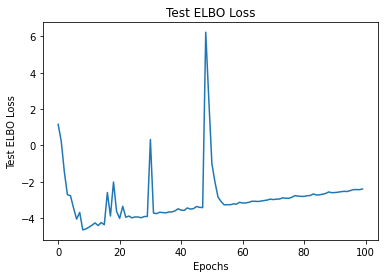

In [69]:
%matplotlib inline
plt.plot(test_loss_list)
plt.title(f"Test ELBO Loss")
plt.ylabel('Test ELBO Loss')
plt.xlabel('Epochs')
if not os.path.exists("plots/"):
    utils.makedirs("plots/")
plt.savefig(f"plots/ELBO Test Loss cluster_{cluster}.pdf", dpi = 150)
plt.show()

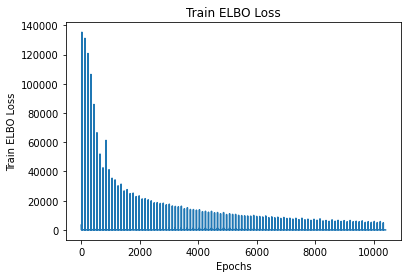

In [70]:
plt.plot(train_loss_list)
plt.title(f"Train ELBO Loss")
plt.ylabel('Train ELBO Loss')
plt.xlabel('Epochs')
if not os.path.exists("plots/"):
    utils.makedirs("plots/")
plt.savefig(f"plots/ELBO Train Loss cluster_{cluster}.pdf", dpi = 150)
plt.show()

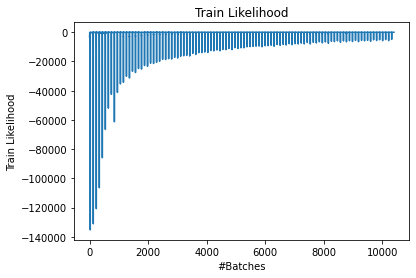

In [71]:
plt.plot(train_likelihood_list)
plt.title(f"Train Likelihood")
plt.ylabel('Train Likelihood')
plt.xlabel('#Batches')
if not os.path.exists("plots/"):
    utils.makedirs("plots/")
plt.savefig(f"plots/Likelihood Train cluster_{cluster}.pdf", dpi = 150)
plt.show()

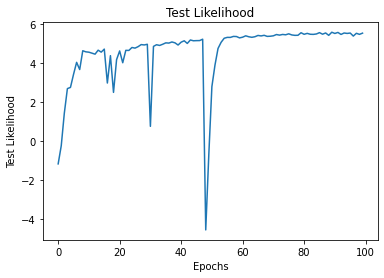

In [72]:
plt.plot(test_likelihood_list)
plt.title(f"Test Likelihood")
plt.ylabel('Test Likelihood')
plt.xlabel('Epochs')
if not os.path.exists("plots/"):
    utils.makedirs("plots/")
plt.savefig(f"plots/Likelihood Test cluster_{cluster}.pdf", dpi = 150)
plt.show()

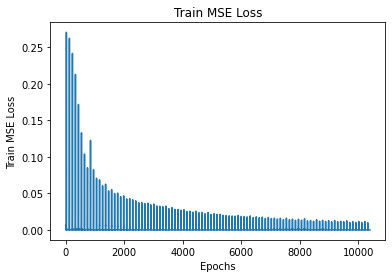

In [73]:
plt.plot(train_mse_list)
plt.title(f"Train MSE Loss")
plt.ylabel('Train MSE Loss')
plt.xlabel('Epochs')
if not os.path.exists("plots/"):
    utils.makedirs("plots/")
plt.savefig(f"plots/MSE Loss Train cluster_{cluster}.pdf", dpi = 150)
plt.show()

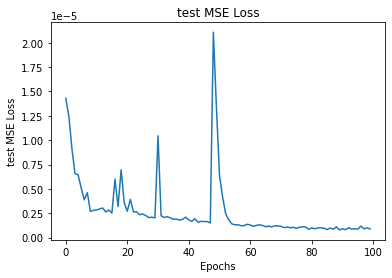

In [74]:
plt.plot(test_mse_list)
plt.title(f"test MSE Loss")
plt.ylabel('test MSE Loss')
plt.xlabel('Epochs')
if not os.path.exists("plots/"):
    utils.makedirs("plots/")
plt.savefig(f"plots/MSE Loss Test cluster_{cluster}.pdf", dpi = 150)
plt.show()

In [75]:
np.save(f"test_elboloss_cluster_{cluster}.npy", test_loss_list)

In [76]:
np.save(f"train_likelihood_cluster_{cluster}.npy", train_likelihood_list)
np.save(f"test_likelihood_cluster_{cluster}.npy", test_likelihood_list)
np.save(f"train_mse_cluster_{cluster}.npy", train_mse_list)
np.save(f"test_mse_cluster_{cluster}.npy", test_mse_list)
np.save(f"train_kl_first_p_cluster_{cluster}.npy", train_kl_first_p_list)
np.save(f"test_kl_first_p_cluster_{cluster}.npy", test_kl_first_p_list)
np.save(f"train_std_first_p_cluster_{cluster}.npy", train_std_first_p_list)
np.save(f"test_std_first_p_cluster_{cluster}.npy", test_std_first_p_list)

In [77]:
np.save(f"kl_coef_cluster_{cluster}.npy", kl_coef_list)

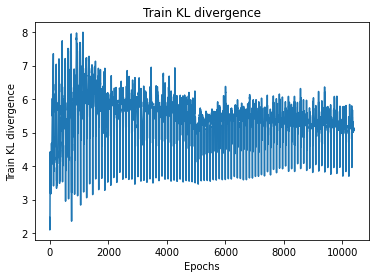

In [79]:
plt.plot(train_kl_first_p_list)
plt.title(f"Train KL divergence")
plt.ylabel('Train KL divergence')
plt.xlabel('Epochs')
if not os.path.exists("plots/"):
    utils.makedirs("plots/")
plt.savefig(f"plots/KL Divergence Train cluster_{cluster}.pdf", dpi = 150)
plt.show()

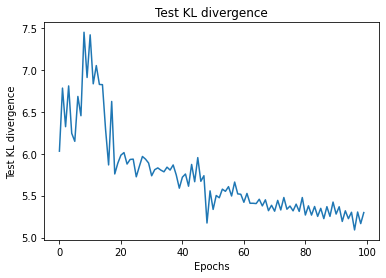

In [80]:
plt.plot(test_kl_first_p_list)
plt.title(f"Test KL divergence")
plt.ylabel('Test KL divergence')
plt.xlabel('Epochs')
if not os.path.exists("plots/"):
    utils.makedirs("plots/")
plt.savefig(f"plots/KL Divergence Test cluster_{cluster}.pdf", dpi = 150)
plt.show()